# World Data League 2022

## 🎯 Challenge
*Identification of Dark Ecological Corridors*


## Team: Bayesciamella
## 👥 Authors
* Natascia Caria
* Claudia Cozzolino
* Alfredo Petrella

## 💻 Development

### Introduction

Artificial light at night (ALAN) has been nowadays recognized as one of major human burden on environment. Recent estimates have shown a 24% increase in light pollution in the UK between 1993 and 2000: it is a real environmental emergency that puts global biodiversity at risk, altering the circadian rhythms and habits of many animals.
Bats, as strictly insectivorous nocturnal animals,revealed to be one of the most vulnerable species for this phenomenon. Light pollution expecially reduces their foraging opportunities as well as their reproductive and social behaviors.
Ecological interventions should be implemented worldwide to curb this effect. To this purpose, the city of Bristol, one of the largest city in South West England, has declared climate and ecological emergencies and is taking concrete actions to meet to reduce human burden on nature. To assess the impact of lighting on bats and insects, the Bats and Lighting Research Project was initiated in 2007. The local council has planned to create dark ecological corridors where bats can thrive and move. Street lighting will be controlled by a Central Management System (CMS) which should be smartly programmed taking into account bats needs as well as public security.

### Install and load requirements

In [ ]:
!pip install matplotlib==3.5.2 osmnx geopandas pyclustering osmium

In [2]:
#### Load libraries ####

import os
import sys
import json
import pickle
import logging

import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.figure_factory as ff

import pyproj
import osmnx as ox
import geopandas as gpd
import osmium
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import networkx as nx
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

# Google services
from google.colab import drive

In [3]:
# Logging config
logging.basicConfig(
    format='%(asctime)s | %(levelname)s : %(message)s',
    level=logging.INFO, stream=sys.stdout
)

In [4]:
#### Working paths ####

mainPath = '/content/gdrive/MyDrive/WorldDataLeague/Finals/\
Identification_of_Dark_Ecological_Corridors'

# Point Colaboratory to My Drive
drive.mount('/content/gdrive/')
os.chdir(mainPath)

# Data folder
dataPath = os.path.join(mainPath, "data")
if not os.path.exists(dataPath):
  # Create directory
  os.makedirs(dataPath)
  logging.info(f"Directory created at: {dataPath}")

logging.info(f"Working directory: {os.getcwd()}")

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
2022-06-15 03:55:31,829 | INFO : Working directory: /content/gdrive/MyDrive/WorldDataLeague/Finals/Identification_of_Dark_Ecological_Corridors


 ### Request Data

#### Bristol datasets

[data source](https://wdl-data.fra1.digitaloceanspaces.com/bristol/2022_05_30_bristol_datasets.zip)

| **Dataset Name** | **Dataset Description** | **Number of Rows** | **Granularity** | **Link** |
|---|---|---|---|---|
| streetlights_2022 | Information on properties and location of streetlights in Bristol (2022) | 36899 | One Row per Streetlight | HOSTED BY WDL |
| bat_records | Data on bat populations in Bristol (1923 - 2021) | 2468 | One Row per Bat recorded | " |
| dark_corridors | Information on Dark Corridors in Bristol (2020) | 64 | One Row per Corridor | " |
| noctua_pronuba | Data on populations of Noctua pronuba (Large Yellow Underwing moth) in Bristol (aggregated 1968 - 2021) | 1834 | One Row per Moth recorded | " |
| green_alley | Green Alley Data (2016) | 197 | One Row per Alley | " |
| green_alley_species | Records of plant species found in Bristol between 2015-2016 | 5985 | One Row per recorded Plant | " |
| wildlife_corridors | Data on current Wildlife corridors in Bristol | 338 | One Row per wildlife corridor | " |

In [5]:
%%bash
if [ ! -f "data/bristol_datasets.zip" ]; then
    echo "Downloading bristol_datasets.zip"
    wget https://wdl-data.fra1.digitaloceanspaces.com/bristol/2022_05_30_bristol_datasets.zip \
        -qO data/bristol_datasets.zip && \
    unzip data/bristol_datasets.zip \
        -d data/bristol_datasets
fi

In [6]:
bristolDataPath = os.path.join(
    dataPath, 'bristol_datasets', 'datasets'
)

### Bat records

#### Description


*   Data on bat populations in Bristol (1923 - 2021)

*   One Row per Bat recorded

*   2468 rows

Records of bats that were recently spotted (within the last 10 years) were obscured
to 1km in resolution for security purposes. Bat records older than 10 years are
provided at full resolution, except for records that identify roosts - these are also
provided at 1km resolution. (BRERC)

#### Load data

In [7]:
# Read csv as pandas dataframe
bat_records_df = pd.read_csv(
    os.path.join(
        bristolDataPath,
        "bat_records.csv"
    ),
    index_col=0
)

#### Preprocessing

In [8]:
# Columns name converter: lower case and raplace space with underscore
columns_name_converter  = lambda x: x.lower().replace(' ', '_')
bat_records_df.columns = list(map(columns_name_converter, bat_records_df.columns))

In [9]:
# Convert "DATE_OF_RE" to datetime
bat_records_df["period_of_re"] = bat_records_df.pop('date_of_re')
bat_records_df["date_of_re"] = pd.to_datetime(
    bat_records_df.loc[:, "period_of_re"],
    format="%d/%m/%Y", errors='coerce'
)

In [10]:
# Convert "YEAR_DATE" to datetime
bat_records_df.loc[:, "year_date"] = pd.to_datetime(
    bat_records_df.loc[:, "year_date"], format="%Y"
)

In [11]:
# Convert UK grid coordinates (Easting, Northing) to (Latitude, Longitude)

def EastNorth_to_LatLon(easting, northing):
  
  # define transformer
  transformer = pyproj.Transformer.from_crs('epsg:27700', 'epsg:4326')

  UK_coords = list(zip(easting, northing))

  # apply transformation
  lat_lon = [transformer.transform(*coords) for coords in UK_coords]

  latitude  = [coord[0] for coord in lat_lon]
  longitude = [coord[1] for coord in lat_lon]

  return latitude, longitude

In [12]:
# Columns Latitude, Longitude from Easting, Northing
bat_records_df["lat"], bat_records_df["lon"] = EastNorth_to_LatLon(
    bat_records_df.easting, bat_records_df.northing
)

In [13]:
# Numeric abundance
numeric_abundance_dict = {
    'present': '1',
    '1+': '1',
    '2+': '2',
    'several': '5',
    'many': '5',
    'few': '2',
    'none': '1',
    'abundant': '5',
    '2-3': '2',
    '10 approx': '10'
}

bat_records_df['numeric_abundance'] = bat_records_df['abundance'].str.lower(
).replace(numeric_abundance_dict).astype('int')

#### EDA

Let's first give a look at the available bats' records

##### Species of bats reported

In [14]:
# Number of reports per specie of bat
bat_records_by_specie = bat_records_df.groupby(
    ["scientific"]
).size().to_frame("num_records"
).sort_values("num_records", ascending=False)

bat_records_by_specie["approx_abundance"] = bat_records_df.groupby(
    ["scientific"]
).numeric_abundance.sum()

bat_records_by_specie.head(10)

num_records  approx_abundance
scientific                                                              
Pipistrellus pipistrellus (sensu stricto)          523              2910
Chiroptera                                         382               772
Nyctalus noctula                                   264               397
Rhinolophus hipposideros                           255               257
Pipistrellus pipistrellus (sensu lato)             245               494
Pipistrellus pygmaeus                              192               263
Eptesicus serotinus                                112               121
Nyctalus leisleri                                  103               111
Rhinolophus ferrumequinum                           87                87
Myotis                                              67                75

##### Bats spotted over time

In [ ]:
# Time series dataframe
ts_bat_records = bat_records_df.sort_values('year_date')
ts_bat_records.index = ts_bat_records['year_date']
ts_bat_records.drop('year_date', axis=1, inplace=True)

# Choose resample
resample_freq = 'Y'

# Choose bat species
species = bat_records_by_specie.index[:10].tolist()

fig = px.line(
    ts_bat_records.loc[
        ts_bat_records.scientific.isin(species)
    ].groupby(
        'scientific'
    ).resample(resample_freq)['scientific'].size().to_frame("num_records"
    ).reset_index(),
    x='year_date', y="num_records", color='scientific',
    labels={"scientific": "Bat Specie", "year_date": "Year",
            "num_records": "N. of bats' records"},
    title=f"Time series of n. of bats' records per specie of bat"
)

# Add range slider
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=5,
                     label="5y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

fig.show()

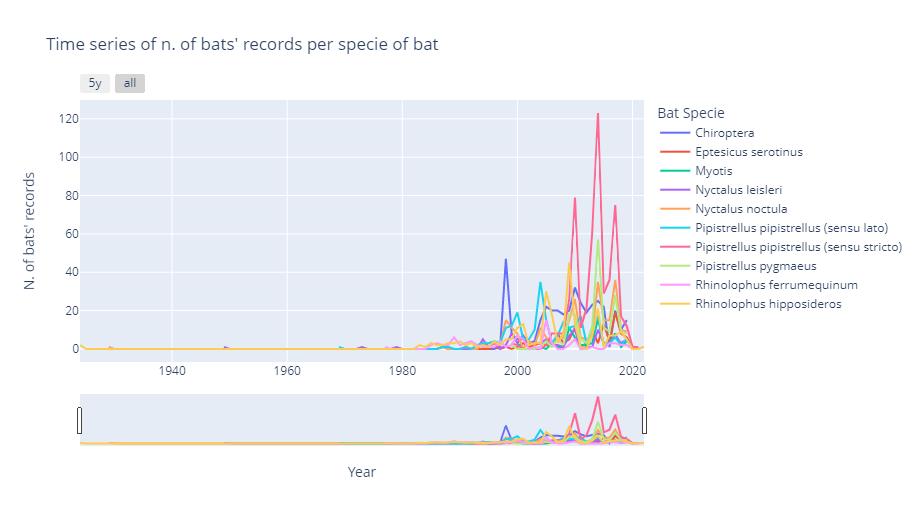

##### ... and locations

Looking at the geographic distribution of bats and moths' reports over time, we noticed that locations change significantly over time.

Moreover, the data seems to be reliable only until 2018: in subsequent years the number of locations where the reports take place have significantly decreased.

###### yearly bats' behavior

In [ ]:
# Scatter map
bat_records_ts_to_plot = ts_bat_records.groupby(
        ['lat', 'lon']
    ).resample(resample_freq)['scientific'].size().to_frame("num_records"
    ).reset_index()
bat_records_ts_to_plot['year'] = bat_records_ts_to_plot.year_date.apply(
    lambda dt: dt.year
)
time_col = 'year'

bristol_geodata = ox.geocode_to_gdf(f'Bristol, UK')

fig = (
    px.scatter_mapbox(
        bat_records_ts_to_plot.loc[
            bat_records_ts_to_plot[time_col]>=1992
        ],
        lat="lat",
        lon="lon",
        animation_frame=time_col,
        category_orders={
            time_col:list(np.sort(bat_records_ts_to_plot[time_col].unique()))
        },
        hover_data=["num_records"],
        size="num_records",
        color_continuous_scale=px.colors.cyclical.IceFire
    )
    .update_traces(
        mode = "markers", marker_sizemin=5, marker_opacity=1)
    .update_layout(
        mapbox={
            "style": 'carto-positron', #'open-street-map'
            "zoom": 10,
            "layers": [
                {
                    "source": json.loads(
                        bristol_geodata.geometry.to_json()
                    ),
                    "below": "traces",
                    "type": "line",
                    "color": "purple",
                    "line": {"width": 1.5},
                }
            ]
        },
        margin={"l": 0, "r": 0, "t": 0, "b": 0},
    )
)
fig.show()

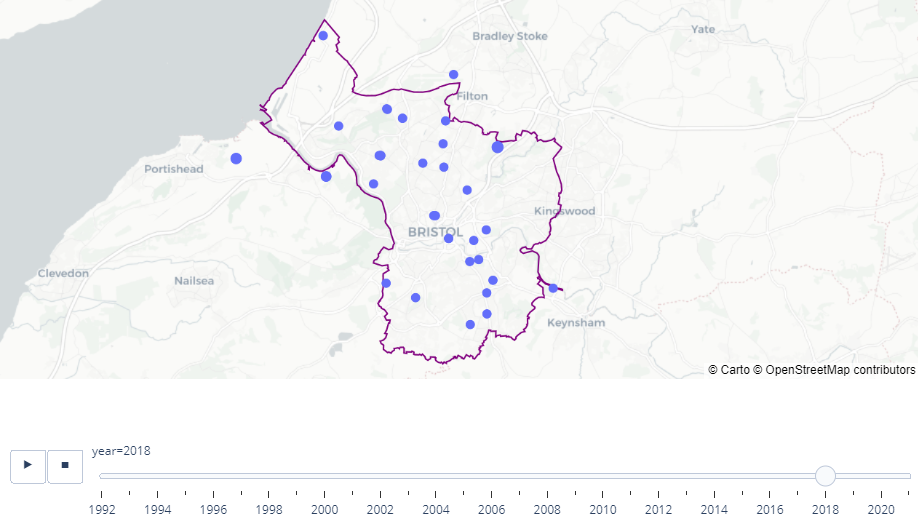

###### seasonal monthly bats' behavior

Below the seasonal behavior of bats is revealed with monthly granularity. It is clear bats are well hidden during their lethargy, while during summer it is possible to spot three clusters in the central part of the map, drawing a triangle, which given the period (June-July), could be associated to the so called *nurseries*, where females are giving birth and are roosting with their offspring.

In [17]:
bat_records_df_plotByMonth = bat_records_df.copy()
bat_records_df_plotByMonth['month'] = bat_records_df.date_of_re.apply(lambda dt: dt.month)
bat_records_df_plotByMonth = bat_records_df_plotByMonth[bat_records_df_plotByMonth.month.notna()]
bat_records_df_plotByMonth['month'] = bat_records_df_plotByMonth['month'].apply(lambda m: str(m))

In [ ]:
fig = (
    px.scatter_mapbox(
        bat_records_df_plotByMonth,
        lat="lat",
        lon="lon",
        animation_frame='month',
        category_orders={
            'month':['1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0', '11.0', '12.0']
        },
    )
    .update_traces(
        mode = "markers", marker_sizemin=5, marker_opacity=1)
    .update_layout(
        mapbox={
            "style": 'carto-positron', #'open-street-map'
            "zoom": 10,
            "layers": [
                {
                    "source": json.loads(
                        bristol_geodata.geometry.to_json()
                    ),
                    "below": "traces",
                    "type": "line",
                    "color": "purple",
                    "line": {"width": 1.5},
                }
            ]
        },
        margin={"l": 0, "r": 0, "t": 0, "b": 0},
    )
)
fig.show()

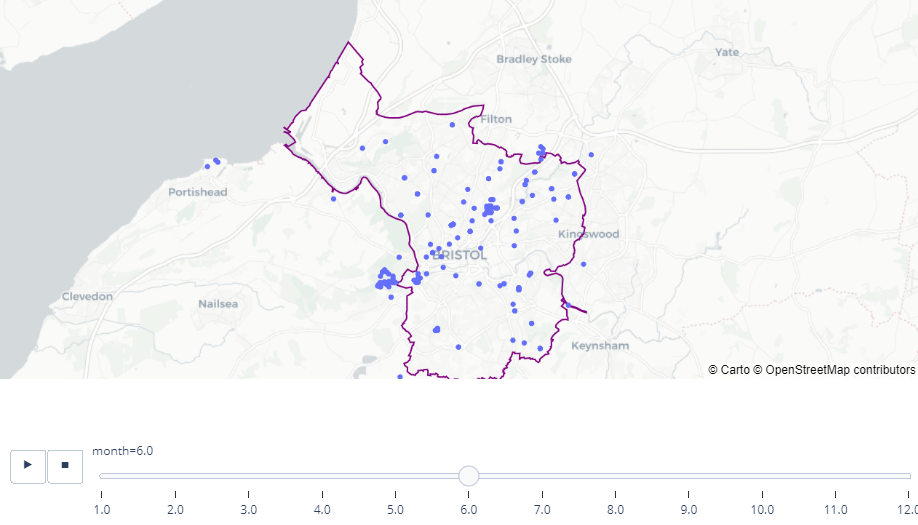

##### Bats communities clusters

We apply X-means to extract clusters that would locate the areas preferred by bats and moths. The advantage of this algorithm, compared to the better-known K-means, is that it does not require the number of clusters to be specified.

In [19]:
# In Bristol Attribute
bristol_geodata = ox.geocode_to_gdf(f'Bristol, UK')
bristol_polygon = bristol_geodata.geometry.values[0]

def point_in_bristol(lat, lon):
    return bristol_polygon.contains(Point(lon, lat))

In [20]:
# define transformer from east-north to lat-lon
eastnorth_to_latlon = pyproj.Transformer.from_crs('epsg:27700', 'epsg:4326')
# define transformer from lat-lon to east-north
latlon_to_eastnorth = pyproj.Transformer.from_crs('epsg:4326', 'epsg:27700')

In [21]:
bat_records_df.head(3)

scientific                   common_nam  \
0     Pipistrellus pipistrellus (sensu lato)    Pipistrelle (45 or 55kHz)   
1                      Pipistrellus pygmaeus  Soprano Pipistrelle (55kHz)   
2  Pipistrellus pipistrellus (sensu stricto)           Common Pipistrelle   

   grid_ref abundance sex_stage    record_typ  \
0  ST605714   Present     adult  bat detector   
1  ST555780   Present   feeding  bat detector   
2  ST555780   Present   feeding  bat detector   

                                 brerc_stat  year_date  easting  northing  \
0                                Widespread 1995-01-01   360500    171400   
1  Proposed BRERC Notable 2004 as protected 1998-01-01   355500    178000   
2  Proposed BRERC Notable 2004 as protected 1998-01-01   355500    178000   

   unique_no period_of_re date_of_re        lat       lon  numeric_abundance  
0   499728.0   04/07/1995 1995-07-04  51.440208 -2.569692                  1  
1   502903.0   01/03/1998 1998-03-01  51.499176 -2.642457                  1  
2   502902.0   01/03/1998 1998-03-01  51.499176 -2.642457                  1

In [22]:
bats_thoroughYears_EastNorth = list(zip(bat_records_df['easting'], bat_records_df['northing']))
bats_thoroughYears_EastNorth = [point for point in bats_thoroughYears_EastNorth if bristol_polygon.contains(Point(eastnorth_to_latlon.transform(*point)[::-1]))]

In [ ]:
# Prepare initial centers
# amount of initial centers defines amount of clusters from which X-Means will
# start analysis
amount_initial_centers = 3

# set seed to allow reproducibility
np.random.seed(0)
initial_centers = kmeans_plusplus_initializer(bats_thoroughYears_EastNorth, amount_initial_centers).initialize()

# Create instance of X-Means algorithm. The algorithm will start analysis from
# 2 clusters, the maximum number of clusters that can be allocated is 10
xmeans_instance = xmeans(bats_thoroughYears_EastNorth, initial_centers, 10)
xmeans_instance.process()

# Extract clustering results: clusters and their centers
clusters = xmeans_instance.get_clusters()
centers = xmeans_instance.get_centers()
centers = sorted(centers, key = lambda x: (x[1], x[0]))

# Visualize clustering results
visualizer = cluster_visualizer()
visualizer.append_clusters(clusters, bats_thoroughYears_EastNorth)
visualizer.append_cluster(centers, None, marker='*', markersize=10)
visualizer.show()

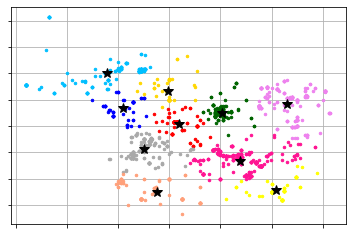

### Moth records

#### Description
* Data on populations of Noctua pronuba (Large Yellow Underwing moth) in Bristol (aggregated 1968 - 2021)

*   One Row per Moth recorded

*   1834 rows


#### Load Data

In [24]:
# Read csv as pandas dataframe
moth_records_df = pd.read_csv(
    os.path.join(
        bristolDataPath,
        "noctua_pronuba.csv"
    ),
    index_col=0
)

#### Preprocessing

In [25]:
# Columns name converter: lower case and raplace space with underscore
columns_name_converter  = lambda x: x.lower().replace(' ', '_')
moth_records_df.columns = list(map(columns_name_converter, moth_records_df.columns))

In [26]:
# Convert "DATE_OF_RE" to datetime
moth_records_df["period_of_record"] = moth_records_df.pop('date_of_record')
moth_records_df["date_of_record"] = pd.to_datetime(
    moth_records_df.loc[:, "period_of_record"],
    format="%d/%m/%Y", errors='coerce'
)

In [27]:
# Convert "YEAR_DATE" to datetime
moth_records_df.loc[:, "year_date"] = pd.to_datetime(
    moth_records_df.loc[:, "year_date"], format="%Y"
)

In [28]:
# Get Easting, Northing coordinates from Grid Reference

def GridRef_to_EastingNorthing(gridRef):
    '''
    Adapted from Javascript code at
    https://www.movable-type.co.uk/scripts/os-grid-dist.html
    '''
    assert len(gridRef) % 2 == 0

    # Get letters from ref
    eastingLetter, northingLetter= gridRef.upper()[0], gridRef.upper()[1]

    # Get Unicode Character
    assert ord(eastingLetter)>=ord("A")  and ord(eastingLetter)<=ord("Z"),  "Invalid input"
    assert ord(northingLetter)>=ord("A") and ord(northingLetter)<=ord("Z"), "Invalid input"

    eastingLetter_index  = ord(eastingLetter) - ord('A')
    northingLetter_index = ord(northingLetter) - ord('A')

    # Shuffle down letters after 'I' since 'I' is not used in grid
    if (eastingLetter_index > 7):  eastingLetter_index  -= 1
    if (northingLetter_index > 7): northingLetter_index -= 1

    # Convert grid letters into 100km-square indexes
    easting = ((eastingLetter_index+3)%5)*5 + (northingLetter_index%5)
    northing = (19-math.floor(eastingLetter_index/5)*5) - math.floor(northingLetter_index/5)

    # Skip grid letters to get numeric part of ref
    numericRef = gridRef[2:]
    eastingNumeric = numericRef[:len(numericRef)//2]
    northingNumeric = numericRef[len(numericRef)//2:]
    
    # Combine letter index and numeric reference
    easting  = str(easting)  + eastingNumeric
    northing = str(northing) + northingNumeric

    # Zero pad to normalise to 1m grid
    easting  = easting.ljust(6, "0")
    northing = northing.ljust(6, "0")

    return int(easting), int(northing)

In [29]:
# Columns Easting, Northing from Grid Reference
moth_records_df["easting"], moth_records_df["northing"] = zip(
    *moth_records_df.grid_ref.apply(
        lambda grid_ref: GridRef_to_EastingNorthing(grid_ref)
    )
)

In [30]:
# Columns Latitude, Longitude from Easting, Northing
moth_records_df["lat"], moth_records_df["lon"] = EastNorth_to_LatLon(
    moth_records_df.easting, moth_records_df.northing
)

In [31]:
# Numeric abundance
numeric_abundance_dict = {
    'present': '1',
    '1+': '1',
    '2+': '2',
    'several': '5',
    'many': '5',
    'few': '2',
    'none': '1',
    'abundant': '5',
    '2-3': '2',
    '10 approx': '10'
}

moth_records_df['numeric_abundance'] = moth_records_df['abundance'].str.lower(
).replace(numeric_abundance_dict).astype('int')

#### EDA

##### Moths spotted over time and **locations**

Although we can see a few stable points, we also see that the location of moths changes significantly over time

In [32]:
# Time series dataframe
ts_moth_records = moth_records_df.sort_values('year_date')
ts_moth_records.index = ts_moth_records['year_date']
ts_moth_records.drop('year_date', axis=1, inplace=True)

# Choose resample
resample_freq = 'Y'

In [ ]:
# Scatter map
moth_records_ts_to_plot = ts_moth_records.groupby(
        ['lat', 'lon']
    ).resample(resample_freq)['scientific_name'].size().to_frame("num_records"
    ).reset_index()
moth_records_ts_to_plot['year'] = moth_records_ts_to_plot.year_date.apply(
    lambda dt: dt.year
)
time_col = 'year'

bristol_geodata = ox.geocode_to_gdf(f'Bristol, UK')

fig = (
    px.scatter_mapbox(
        moth_records_ts_to_plot.loc[
            moth_records_ts_to_plot[time_col]>=1992
        ],
        lat="lat",
        lon="lon",
        animation_frame=time_col,
        category_orders={
            time_col:list(np.sort(moth_records_ts_to_plot[time_col].unique()))
        },
        hover_data=["num_records"],
        size="num_records",
        color_discrete_sequence=['red']
    )
    .update_traces(
        mode = "markers", marker_sizemin=5, marker_opacity=1)
    .update_layout(
        mapbox={
            "style": 'carto-positron', #'open-street-map'
            "zoom": 10,
            "layers": [
                {
                    "source": json.loads(
                        bristol_geodata.geometry.to_json()
                    ),
                    "below": "traces",
                    "type": "line",
                    "color": "purple",
                    "line": {"width": 1.5},
                }
            ]
        },
        margin={"l": 0, "r": 0, "t": 0, "b": 0},
    )
)
fig.show()

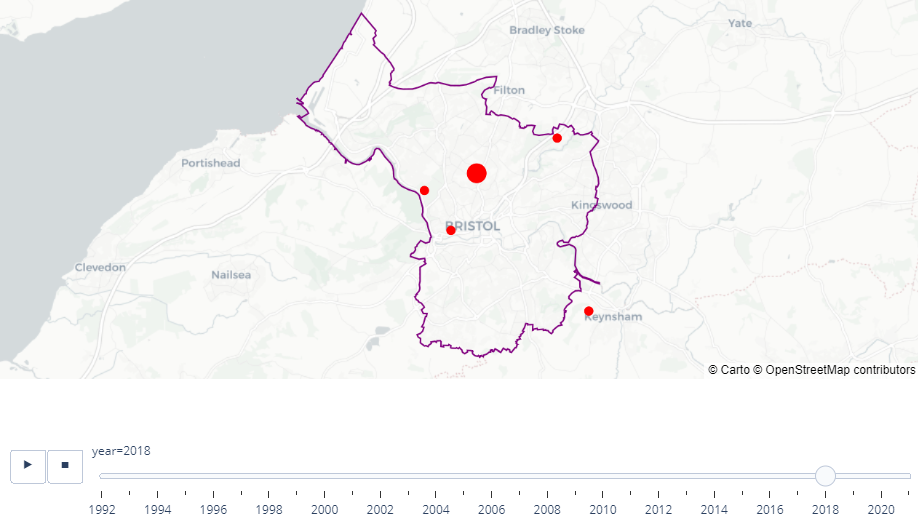

### Street Lights

#### Description

* Information on properties and location of streetlights in Bristol (2022)

* One Row per street lamp

* 36899 rows


#### Load Data

In [34]:
# Read csv as pandas dataframe
street_light_df = pd.read_csv(
    os.path.join(
        bristolDataPath,
        "streetlights_2022.csv"
    ),
    index_col=0
)

#### Preprocessing

In [35]:
# Columns name converter: lower case and raplace space with underscore
columns_name_converter  = lambda x: x.lower().replace(' ', '_')
street_light_df.columns = list(map(columns_name_converter, street_light_df.columns))

In [36]:
# Columns Latitude, Longitude from Easting, Northing
street_light_df["lat"], street_light_df["lon"] = EastNorth_to_LatLon(
    street_light_df.easting, street_light_df.northing
)

In [37]:
# Scatter map
bristol_geodata = ox.geocode_to_gdf(f'Bristol, UK')

fig = (
    px.scatter_mapbox(
        street_light_df[street_light_df.site_code.isin(["4533926"])],
        lat="lat",
        lon="lon",
        color = "ratio",
        hover_data=["ratio", "site_code", "burn_hours"],
    )
    .update_traces(
        mode = "markers", marker_sizemin=5, marker_opacity=0.5)
    .update_layout(
        mapbox={
            "style": 'carto-positron', #'open-street-map'
            "zoom": 13,
            "layers": [
                {
                    "source": json.loads(
                        bristol_geodata.geometry.to_json()
                    ),
                    "below": "traces",
                    "type": "line",
                    "color": "purple",
                    "line": {"width": 1.5},
                }
            ]
        },
        margin={"l": 0, "r": 0, "t": 0, "b": 0},
    )
)
fig.show()

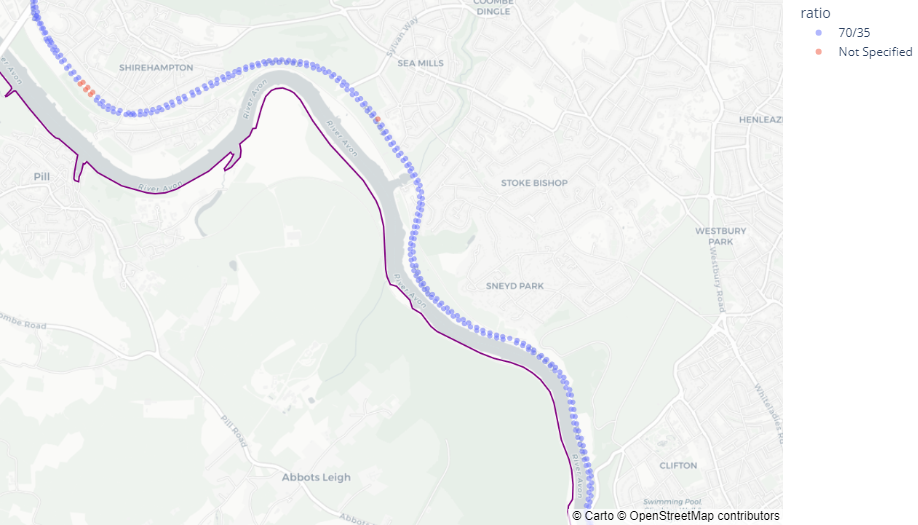



```
# Get mapbox free acceess token from https://www.mapbox.com/
from getpass import getpass
mapboxToken = getpass("Mapbox Public Token:")
px.set_mapbox_access_token(mapboxToken)

fig = ff.create_hexbin_mapbox(
    street_light_df,
    lat = "lat",
    lon = "lon",
    nx_hexagon=15, opacity=0.5, labels={"color": "Num of Street Lights"},
    min_count=1, color_continuous_scale="Viridis",
    show_original_data=False
).update_layout(
        mapbox={
            "style": 'carto-positron', #'open-street-map'
            "zoom": 10,
            "layers": [
                {
                    "source": json.loads(
                        bristol_geodata.geometry.to_json()
                    ),
                    "below": "traces",
                    "type": "line",
                    "color": "purple",
                    "line": {"width": 1.5},
                }
            ]
        },
        margin={"l": 0, "r": 0, "t": 0, "b": 0},
    )
fig.show()
```



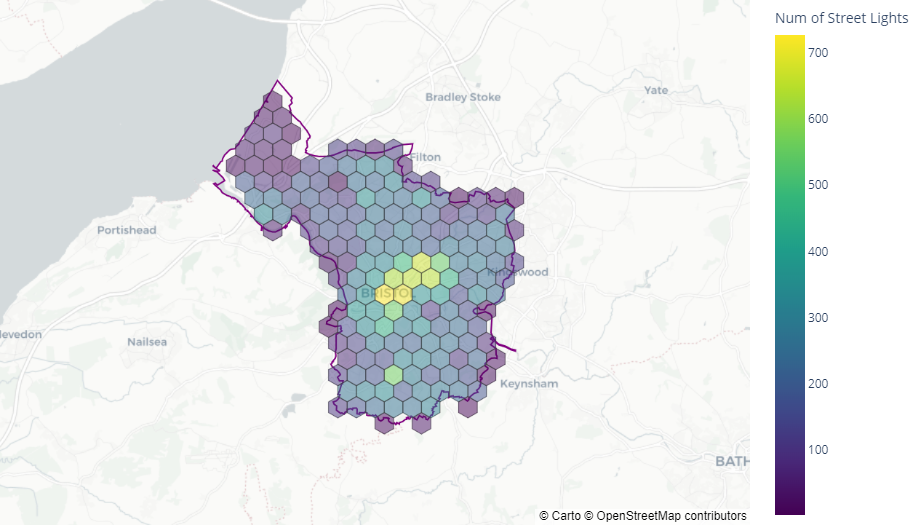

### Green Alley plants


#### Description

* Records of plant species found in Bristol between 2015-2016

* one row per observed plant 

* 5985 rows



#### Load Data

In [40]:
# Read csv as pandas dataframe
green_alley_species_df = pd.read_csv(
    os.path.join(
        bristolDataPath,
        'green_alley_species.csv'
    ),
    index_col=0
)


#### Preprocessing

In [41]:
# clean mistaken cols for violets

correct_str = 'a violet, dog-violet or pansy (unidentified)'
green_alley_species_df.loc[green_alley_species_df.Grid_Ref == ' dog-violet or pansy (unidentified)','Common_Name'] = correct_str

cols_to_slide = ['Grid_Ref',	'Date_of_Record',	'Abundance',	'Sex_Stage', 'Record_Type',	'BERC_Status',	'Year_Date']
for i in range(len(cols_to_slide)-1):
  col1 = cols_to_slide[i]
  col2 = cols_to_slide[i+1]
  green_alley_species_df.loc[green_alley_species_df.Common_Name == correct_str, col1] = green_alley_species_df.loc[green_alley_species_df.Common_Name == correct_str, col2].values

In [42]:
# Columns name converter: lower case and raplace space with underscore
columns_name_converter  = lambda x: x.lower().replace(' ', '_')
green_alley_species_df.columns = list(map(columns_name_converter, green_alley_species_df.columns))

In [43]:
# Columns Easting, Northing from Grid Reference
green_alley_species_df["easting"], green_alley_species_df["northing"] = zip(
    *green_alley_species_df.grid_ref.apply(
        lambda grid_ref: GridRef_to_EastingNorthing(grid_ref)
    )
)

In [44]:
# Columns Latitude, Longitude from Easting, Northing
green_alley_species_df["lat"], green_alley_species_df["lon"] = EastNorth_to_LatLon(
    green_alley_species_df.easting, green_alley_species_df.northing
)

In [45]:
green_alley_species_gdf = gpd.GeoDataFrame(green_alley_species_df,
                                    geometry=gpd.points_from_xy(green_alley_species_df.lon, green_alley_species_df.lat))



#### EDA

In [ ]:
# Scatter map 
fig = (
    px.scatter_mapbox(
        green_alley_species_gdf,
        lat="lat",
        lon="lon"
    )
    .update_layout(
        mapbox={
            "style": "open-street-map",
            "zoom": 11
        },
        margin={"l": 0, "r": 0, "t": 0, "b": 0},
    )
)
fig.show()

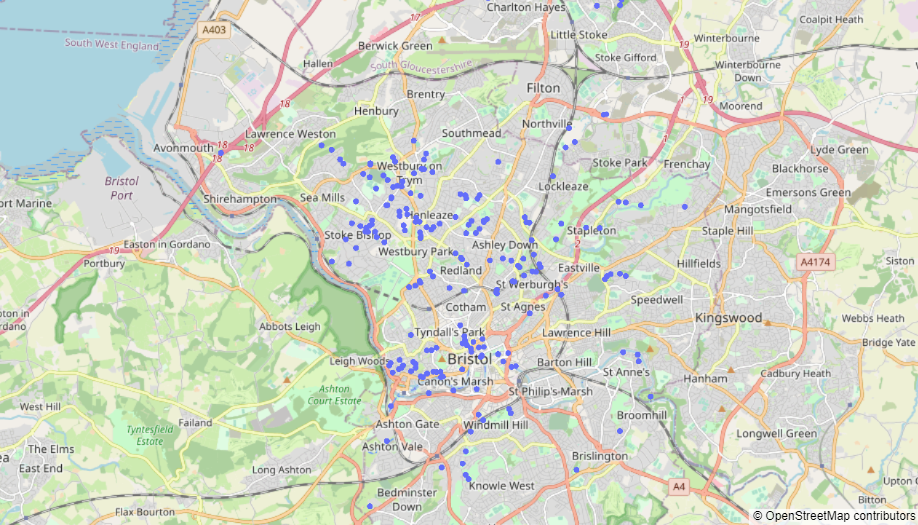

### OSM data

In order not to endanger public safety, optimal dark corridor solution must take into account urban configurations in different parts of the city of Bristol. For this reason, data gathered by the Open Street Map service were exploited.



Download Bristol osm.pbf available at https://download.geofabrik.de/europe/great-britain/england/bristol-latest.osm.pbf

In [47]:
%%bash
if [ ! -f "data/bristol-latest.osm.pbf" ]; then
    echo "Downloading OSM from Geofabrik"
    wget https://download.geofabrik.de/europe/great-britain/england/bristol-latest.osm.pbf \
        -qO data/bristol-latest.osm.pbf
fi

#### Extract nodes with tags of interest

Tags reference link: https://taginfo.openstreetmap.org/
  

In [48]:
src_filepath = '.data/bristol-latest.osm.pbf'

tags_type1 = ['amenity','tourism','healthcare', 'public_transport', 'leisure','historic','office','shop']

In [49]:
# define OSM node handler

class CustomHandler(osmium.SimpleHandler):
    def __init__(self, node_type1):
        super(CustomHandler, self).__init__()
        self.interest_places = []
        self.node_type1 = node_type1

    def node(self, n):  # on nodes
        if n.tags.get(self.node_type1): #and 'name' in n.tags: 
            self.interest_places.append((n.id, self.node_type1, n.tags.get(self.node_type1), n.location.lat, n.location.lon, n.timestamp)) #n.tags['name'],


In [50]:
if not os.path.exists('./data/df_OSM_nodes_extraction.csv' ):

  # extraction
  nodes = []

  for t in tags_type1:
        print(t)  
        h = CustomHandler(t)
        h.apply_file(src_filepath)
        nodes += h.interest_places
      

  # create DataFrame 
  df = pd.DataFrame(nodes, columns =["ID", "tag_type1", "tag_type2", "latitude", "longitude", "timestamp"])

  # manipulate df to have one node per row
  new_rows = []
  for i in df.ID.unique():
      sub = df.loc[df.ID == i]
      tag_type1_encoding = [0]*8
      tags_type2 = [np.nan]*8
      for j in range(sub.shape[0]):
          
          tag_type2 = sub.iloc[j,:].tag_type2
          
          if tag_type2:
              tag_type1 = sub.iloc[j,:].tag_type1
              
              tag_type1_encoding[tags_type1.index(tag_type1)] = 1
              tags_type2[tags_type1.index(tag_type1)] = tag_type2
              
      new_rows.append(tuple([sub.iloc[j,:].ID] + tag_type1_encoding + tags_type2 + [sub.iloc[j,:].latitude, sub.iloc[j,:].longitude, sub.iloc[j,:].timestamp]))
    

          
  # rewrite DataFrame 
  df = pd.DataFrame(new_rows, columns =["ID", 'amenity','tourism','healthcare', 'public_transport', 'leisure','historic','office','shop', 'amenity_type','tourism_type','healthcare_type', 'public_transport_type','leisure_type','historic_type','office_type','shop_type', "latitude", "longitude", "timestamp"])

  # export
  df.to_csv('./data/df_OSM_nodes_extraction.csv', header=True, index=False)

In [51]:
# Read csv as pandas dataframe
OSM_nodes_df = pd.read_csv("./data/df_OSM_nodes_extraction.csv")
 

#### Preprocessing

In [52]:
def LatLon_to_EastNorth(latitude, longitude):
  
  # define transformer
  transformer = pyproj.Transformer.from_crs('epsg:4326', 'epsg:27700')

  latlon_coords = list(zip(latitude, longitude))

  # apply transformation
  eastnorth_coords = [transformer.transform(*coords) for coords in latlon_coords]

  easting  = [coord[0] for coord in eastnorth_coords]
  northing = [coord[1] for coord in eastnorth_coords]

  return easting, northing

In [53]:
# Columns Latitude, Longitude from Easting, Northing
OSM_nodes_df["easting"], OSM_nodes_df["northing"] = LatLon_to_EastNorth(
    OSM_nodes_df.latitude, OSM_nodes_df.longitude
)

In [54]:
# convert to geodataframe
OSM_nodes_gdf = gpd.GeoDataFrame(OSM_nodes_df,
                                    geometry=gpd.points_from_xy(OSM_nodes_df.longitude, OSM_nodes_df.latitude))
  

#### EDA

In [ ]:
# Scatter map 
fig = (
    px.scatter_mapbox(
        OSM_nodes_gdf,
        lat="latitude",
        lon="longitude"
    )
    .update_layout(
        mapbox={
            "style": "open-street-map",
            "zoom": 11
        },
        margin={"l": 0, "r": 0, "t": 0, "b": 0},
    )
)
fig.show()

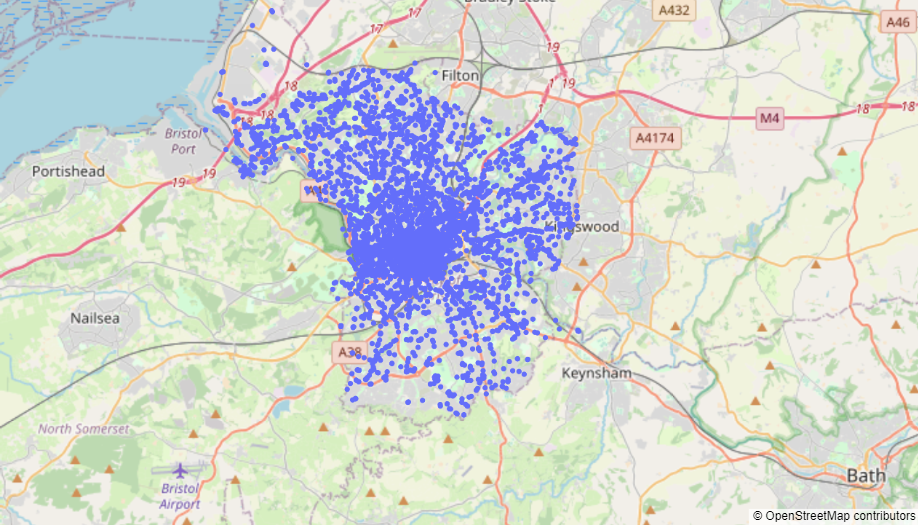

### Social and Road Traffic Safety evaluation

In addition to using amenities to assess the level of urbanisation, we want to give a safety value by considering data on the number of road accidents and crime, factors that can be greatly affected by lack of light.

#### Traffic Accidents

In [56]:
%%bash
if [ ! -f "data/traffic_accidents.geojson" ]; then
    echo "Downloading traffic-accidents.geojson"
    wget https://opendata.bristol.gov.uk/explore/dataset/traffic-accidents0/download/?format=geojson \
        -O data/traffic_accidents.geojson
fi

In [57]:
# Read csv as pandas dataframe
traffic_accidents_gdf = gpd.read_file(
    os.path.join(
        dataPath,
        "traffic_accidents.geojson"
    ),
    index_col=0
)

2022-06-15 03:56:31,847 | WARNING : Skipping field geo_point_2d: invalid type 3


In [58]:
# Easting, Northing coordinates
traffic_accidents_gdf['easting'] = traffic_accidents_gdf.pop("x")
traffic_accidents_gdf['northing'] = traffic_accidents_gdf.pop("y")

# Latitude, Longitude coordinates
traffic_accidents_gdf['latitude'] = traffic_accidents_gdf.geometry.y
traffic_accidents_gdf['longitude'] = traffic_accidents_gdf.geometry.x

In [59]:
# Datetime 
traffic_accidents_gdf["datetime"] = traffic_accidents_gdf[
    ['date', 'time']
].agg(' '.join, axis=1)

# Convert "datetime" to datetime
traffic_accidents_gdf.loc[:, "datetime"] = pd.to_datetime(
    traffic_accidents_gdf.loc[:, "datetime"], format="%Y-%m-%d %H%M"
)

In [60]:
traffic_accidents_gdf["dark_light"] =  traffic_accidents_gdf["datetime"].apply(
    lambda d: "dark" if (d.hour>20 or d.hour<6) else "light"
)

Here we can have an insigt of the incidents in the centre of Bristol, distinguishing between those occurring during the day or night hours

In [ ]:
# Scatter map
bristol_geodata = ox.geocode_to_gdf(f'Bristol, UK')

traffic_accidents_dark = traffic_accidents_gdf.loc[traffic_accidents_gdf.dark_light=="dark"]
fig = (
    px.scatter_mapbox(
        traffic_accidents_gdf,
        lat = "latitude",
        lon = "longitude",
        color = "dark_light"
    )
    .update_traces(
        mode = "markers", marker_sizemin=5, marker_opacity=0.5)
    .update_layout(
        mapbox={
            "style": 'carto-positron', #'open-street-map'
            "zoom": 13,
            "layers": [
                {
                    "source": json.loads(
                        bristol_geodata.geometry.to_json()
                    ),
                    "below": "traces",
                    "type": "line",
                    "color": "purple",
                    "line": {"width": 1.5},
                }
            ]
        },
        margin={"l": 0, "r": 0, "t": 0, "b": 0},
    )
)
fig.show()

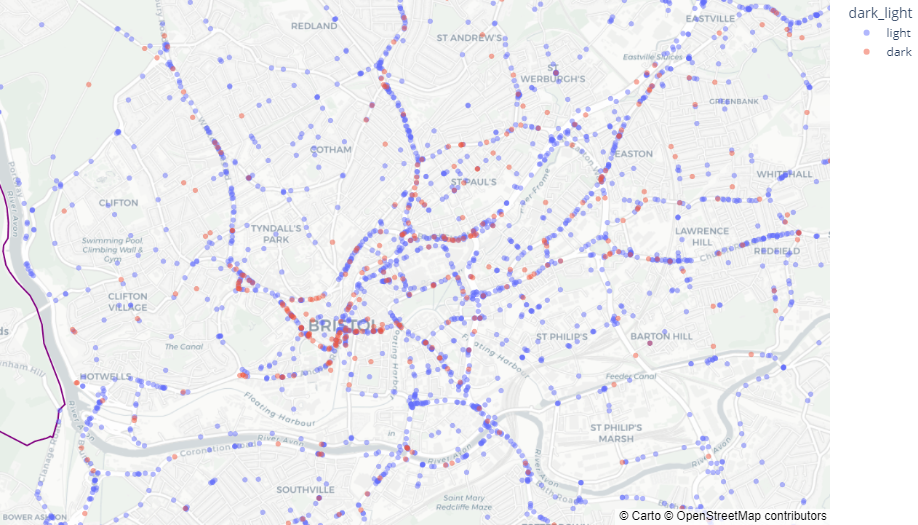

The area most affected by accidents is actually the most urbanised area

#### Criminality Index

In [63]:
%%bash
if [ ! -f "data/crime_records.geojson" ]; then
    echo "Downloading crime_records.geojson"
    wget https://opendata.bristol.gov.uk/explore/dataset/crime-recorded-by-police-by-selected-offence-groups-in-bristol-by-ward/download/?format=geojson \
        -O data/crime_records.geojson
fi

In [64]:
# Read csv as pandas dataframe
crime_records_gdf = gpd.read_file(
    os.path.join(
        dataPath,
        "crime_records.geojson"
    ), crs="EPSG:4326"
)
crime_records_gdf.dropna(inplace=True)

2022-06-15 03:56:33,871 | WARNING : Skipping field geo_point_2d: invalid type 3


In [65]:
crime_records_gdf_2018 = crime_records_gdf.loc[
    crime_records_gdf.year=='2018/19'].set_index("ward_code")

Also for crime, we see that the less safe area is in Bristol Central ward

In [ ]:
crime_records_gdf_2018_json = json.loads(crime_records_gdf_2018.to_json())

fig = px.choropleth_mapbox(
    crime_records_gdf_2018,
    geojson=crime_records_gdf_2018_json,
    locations=crime_records_gdf_2018.index,
    color="all_crimes_rate_per_1000_ward_population",
    color_continuous_scale="Viridis",
    opacity = 0.5,
    hover_data = ["ward_name", "all_crimes_number",
                  "all_crimes_rate_per_1000_ward_population"],
    labels = {
        "ward_name": "Ward",
        "ward_code": "Ward Code",
        "all_crimes_number": "Tot crimes",
        "all_crimes_rate_per_1000_ward_population": "Crimes per 100k population"
    },
    mapbox_style="carto-positron", zoom=10,
    center={"lat": 51.48, "lon": -2.59}
).update_layout(
        mapbox={
            "layers": [
                {
                    "source": json.loads(
                        bristol_geodata.geometry.to_json()
                    ),
                    "below": "traces",
                    "type": "line",
                    "color": "purple",
                    "line": {"width": 1.5},
                }
            ]
        },
        margin={"l": 0, "r": 0, "t": 0, "b": 0},
    )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

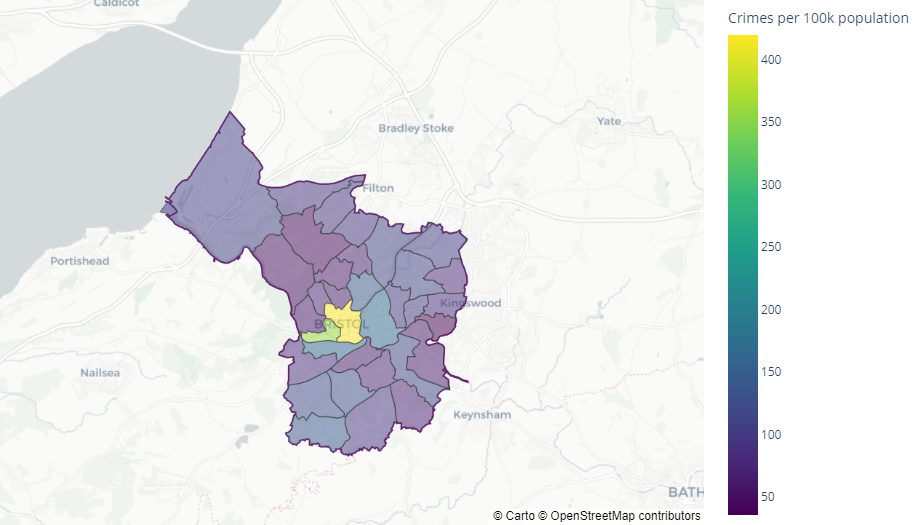

### Identification of Dark Ecological Corridors

##### Square grid plane tessellation

To reduce the spatial dimensionality of the problem, we approximate the plane by tessellating it with a grid of squares.

To do this, we exploit the UK coordinate system: in practice we simply truncate the grid references to 4 digits, to resolve to 1km squares.

In [67]:
# Grid Reference boundaries
bottom_left_start = "ST5066"
top_right_end = "ST6684"

In [68]:
# Easting and Northing boundaries
east_start, north_start = GridRef_to_EastingNorthing(bottom_left_start)
east_end, north_end = GridRef_to_EastingNorthing(top_right_end)

In [69]:
# Latitude and longirude boundaries
transformer = pyproj.Transformer.from_crs('epsg:27700', 'epsg:4326')

lat_start, lon_start = transformer.transform(east_start, north_start)
lat_end, lon_end = transformer.transform(east_end, north_end)

In [70]:
print(
    f"Bottom Left Start:\n\
    \t- Grid Ref: {bottom_left_start}\n \
    \t- Easting, Norting: ({east_start}, {north_start})\n \
    \t- Latitude, Longitude: ({round(lat_start, 3)}, {round(lon_start, 3)})"
)

Bottom Left Start:
    	- Grid Ref: ST5066
     	- Easting, Norting: (350000, 166000)
     	- Latitude, Longitude: (51.391, -2.72)


In [71]:
print(
    f"Top Right End:\n\
    \t- Grid Ref: {top_right_end}\n \
    \t- Easting, Norting: ({east_end}, {north_end})\n \
    \t- Latitude, Longitude: ({round(lat_end, 3)}, {round(lon_end, 3)})"
)

Top Right End:
    	- Grid Ref: ST6684
     	- Easting, Norting: (366000, 184000)
     	- Latitude, Longitude: (51.554, -2.492)


In [72]:
num_1km_easting_boxes  = int(str(east_end)[:3])  - int(str(east_start)[:3])
num_1km_northing_boxes = int(str(north_end)[:3]) - int(str(north_start)[:3])

In [73]:
east_range  = [x*10**3 for x in range(east_start//10**3, east_end//10**3)]
north_range = [x*10**3 for x in range(north_start//10**3, north_end//10**3)]

In [74]:
grid_EastingNorthing = [
    [(x,y) for x in east_range] for y in north_range[::-1]
]

grid_LatLon = [
    [transformer.transform(x,y) for x in east_range] for y in north_range[::-1]
]

In [ ]:
fig = (
    px.scatter_mapbox(
        lat=[transformer.transform(x,y)[0] for x in east_range for y in north_range[::-1]],
        lon=[transformer.transform(x,y)[1] for x in east_range for y in north_range[::-1]]
    )
    .update_traces(
        mode = "markers", marker_sizemin=10, marker_opacity=1)
    .update_layout(
        mapbox={
            "style": 'carto-positron', #'open-street-map'
            "zoom": 10,
            "layers": [
                {
                    "source": json.loads(
                        bristol_geodata.geometry.to_json()
                    ),
                    "below": "traces",
                    "type": "line",
                    "color": "purple",
                    "line": {"width": 1.5},
                }
            ]
        },
        margin={"l": 0, "r": 0, "t": 0, "b": 0},
    )
)
fig.show()

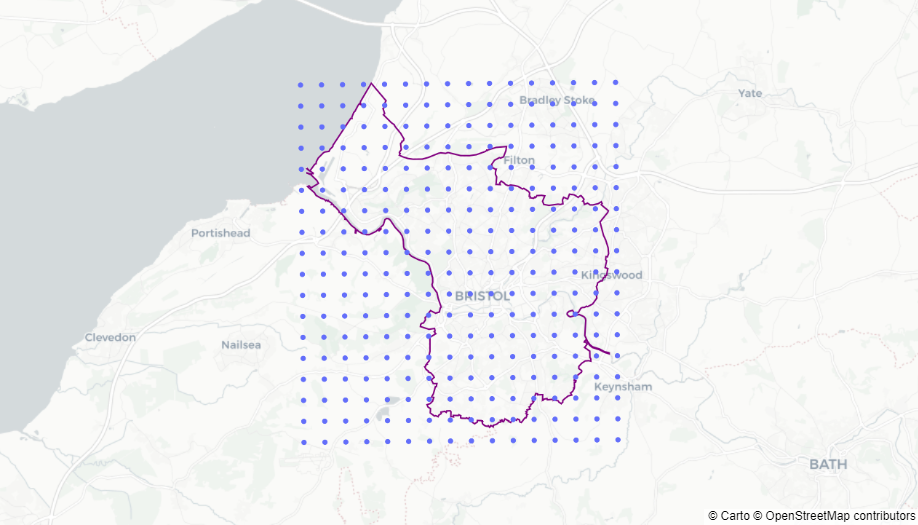

In [76]:
# Create a 2 dimensional grid graph
grid_graph = nx.grid_2d_graph(
    num_1km_easting_boxes, num_1km_northing_boxes, periodic=False
)

grid_graph.add_edges_from([
    ((x, y), (x+1, y+1))
    for x in range(num_1km_easting_boxes-1)
    for y in range(num_1km_northing_boxes-1)
] + [
    ((x+1, y), (x, y+1))
    for x in range(num_1km_easting_boxes-1)
    for y in range(num_1km_northing_boxes-1)
])

In [77]:
# Grif Reference Attribute
eastingRefStart = int(bottom_left_start[2:4])
northingRefStart = int(bottom_left_start[4:6])

nx.set_node_attributes(
    grid_graph,
    {node_xy: f"ST{node_xy[0]+eastingRefStart}{node_xy[1]+northingRefStart}" for
     node_xy in grid_graph.nodes()},
    name="grid_ref"
)

In [78]:
# Easting Northing Attribute
nx.set_node_attributes(
    grid_graph,
    {node: GridRef_to_EastingNorthing(data['grid_ref']) for
     node, data in grid_graph.nodes(data=True)},
    name="easting_northing"
)

In [79]:
# Latitude Longitude Attribute
nx.set_node_attributes(
    grid_graph,
    {node: transformer.transform(*data['easting_northing']) for
     node, data in grid_graph.nodes(data=True)},
    name="latitude_longitude"
)

In [80]:
# In Bristol Attribute
bristol_geodata = ox.geocode_to_gdf(f'Bristol, UK')
bristol_polygon = bristol_geodata.geometry.values[0]

def point_in_bristol(lat, lon):
    return bristol_polygon.contains(Point(lon, lat)) 

nx.set_node_attributes(
    grid_graph,
    {node: point_in_bristol(*data['latitude_longitude']) for
     node, data in grid_graph.nodes(data=True)},
    name="in_bristol"
)

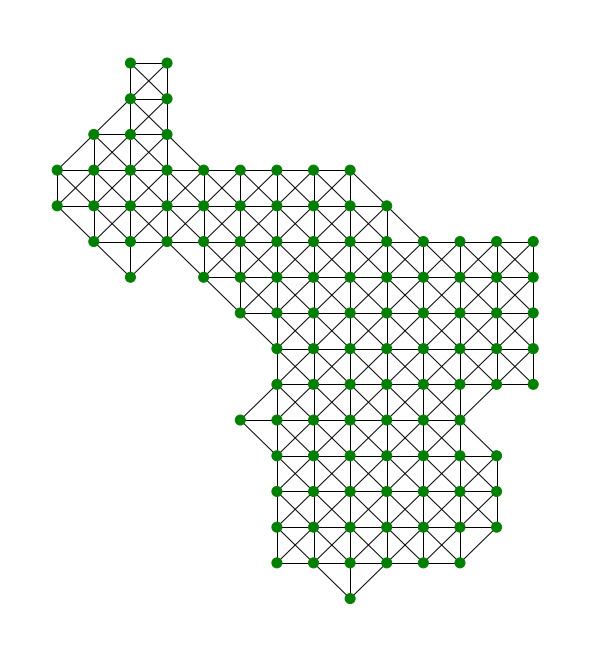

In [81]:
bristol_nodes = [
    node for node, data in grid_graph.nodes(data=True) if
    data.get("in_bristol") == True
]
bristol_grid_graph = grid_graph.subgraph(bristol_nodes)

# Plot Graph
plt.figure(figsize=(8,9))
pos = {(x,y):(x,y) for x,y in bristol_grid_graph.nodes()}
labels = nx.get_node_attributes(bristol_grid_graph, 'grid_ref'),
colors = ['green' if data['in_bristol']==True else 'red' for
          node, data in bristol_grid_graph.nodes(data=True)]
nx.draw(
    bristol_grid_graph, pos=pos,
    node_color = colors,
    node_size=100
)

###### Nodes Environmental Attributes

In [82]:
def get_approximated_EastNorth_coords(east, north):
  # assume boxes are identified by bottom left vertex
  approx_coords = (int(str(east)[:3]+'000'), int(str(north)[:3]+'000'))
  return approx_coords

**Number of Bats**

In [83]:
# Number of bats per 1km box
bats_per_grid_box = bat_records_df[['year_date', 'easting', 'northing', 'numeric_abundance']].copy()

bats_per_grid_box['eastNorth_grid_box'] = bats_per_grid_box[['easting','northing']].apply(
    lambda x: get_approximated_EastNorth_coords(*x), axis=1)

bats_per_grid_box = bats_per_grid_box.groupby('eastNorth_grid_box').numeric_abundance.sum().to_dict()

In [84]:
# Set as node attribute
nx.set_node_attributes(
    bristol_grid_graph,
    {node: bats_per_grid_box.get(data['easting_northing'], 0) for
     node, data in bristol_grid_graph.nodes(data=True)},
    name="number_of_bats"
)

In [85]:
def bats_reward(num_bats, max_reward=10):
    return (min(num_bats+1, 50)) * max_reward/50

def bats_cost(num_bats, max_cost=10):
    return max_cost - bats_reward(num_bats, max_cost)

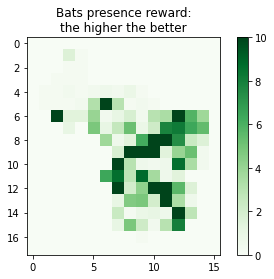

In [86]:
batsReward_graphGrid = np.zeros((num_1km_northing_boxes, num_1km_easting_boxes))

for node in sorted(bristol_grid_graph.nodes()):
    x = num_1km_northing_boxes - node[1] - 1
    y = node[0]
    batsReward_graphGrid[x, y] = bats_reward(
        bristol_grid_graph.nodes[node]["number_of_bats"])

fig = plt.imshow(batsReward_graphGrid, cmap='Greens')
plt.colorbar(fig, cmap='Greens')
plt.title("Bats presence reward:\nthe higher the better")
plt.show()

**Number of Moths**

In [87]:
# Number of moths per 1km box
moths_per_grid_box = moth_records_df[['year_date', 'easting', 'northing', 'numeric_abundance']].copy()

moths_per_grid_box['eastNorth_grid_box'] = moths_per_grid_box[['easting','northing']].apply(
    lambda x: get_approximated_EastNorth_coords(*x), axis=1)

moths_per_grid_box = moths_per_grid_box.groupby('eastNorth_grid_box').numeric_abundance.sum().to_dict()

In [88]:
# Set as node attribute
nx.set_node_attributes(
    bristol_grid_graph,
    {node: moths_per_grid_box.get(data['easting_northing'], 0) for
     node, data in bristol_grid_graph.nodes(data=True)},
    name="number_of_moths"
)

In [89]:
def moths_reward(num_moths, max_reward=10):
    return (min(num_moths + 1, 5)) * max_reward/5

def moths_cost(num_moths, max_cost=10):
    return max_cost - moths_reward(num_moths, max_cost)

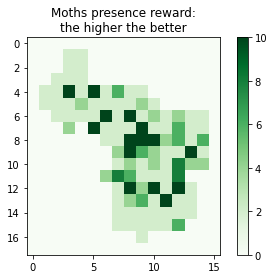

In [90]:
mothsReward_graphGrid = np.zeros((num_1km_northing_boxes, num_1km_easting_boxes))

for node in sorted(bristol_grid_graph.nodes()):
    x = num_1km_northing_boxes - node[1] - 1
    y = node[0]
    mothsReward_graphGrid[x, y] = moths_reward(
        bristol_grid_graph.nodes[node]["number_of_moths"])

fig = plt.imshow(mothsReward_graphGrid, cmap='Greens')
plt.colorbar(fig, cmap='Greens')
plt.title("Moths presence reward:\nthe higher the better")
plt.show()

**Lights**

In [91]:
# Number of moths per 1km box
lights_per_grid_box = street_light_df[['easting', 'northing']].copy()

lights_per_grid_box['eastNorth_grid_box'] = lights_per_grid_box[['easting','northing']].apply(
    lambda x: get_approximated_EastNorth_coords(*x), axis=1
)

lights_per_grid_box = lights_per_grid_box.groupby('eastNorth_grid_box').size().to_dict()

In [92]:
# Set as node attribute
nx.set_node_attributes(
    bristol_grid_graph,
    {node: lights_per_grid_box.get(data['easting_northing'], 0) for
     node, data in bristol_grid_graph.nodes(data=True)},
    name="number_of_street_lights"
)

In [93]:
def lights_reward(num_lights, max_reward=10):
    return max_reward - min(num_lights//50+1, 10) * max_reward/10

def lights_cost(num_lights, max_reward=10):
    return max_reward - lights_reward(num_lights, max_reward)

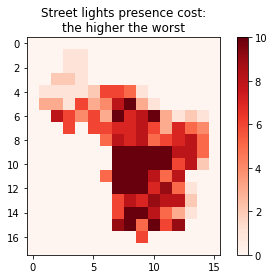

In [94]:
lightsReward_graphGrid = np.zeros((num_1km_northing_boxes, num_1km_easting_boxes))

for node in sorted(bristol_grid_graph.nodes()):
    x = num_1km_northing_boxes - node[1] - 1
    y = node[0]
    lightsReward_graphGrid[x, y] = lights_cost(
        bristol_grid_graph.nodes[node]["number_of_street_lights"]
    )

fig = plt.imshow(lightsReward_graphGrid, cmap='Reds')
plt.title("Street lights presence cost:\nthe higher the worst")
plt.colorbar(fig, cmap='Reds')
plt.show()

**Number of Accidents**

In [95]:
# Number of accidents per 1km^2 box
dark_traffic_accidents_box = traffic_accidents_gdf.loc[traffic_accidents_gdf.dark_light== "dark"].copy()
dark_traffic_accidents_box = dark_traffic_accidents_box[['easting', 'northing']].copy()

dark_traffic_accidents_box['eastNorth_grid_box'] = dark_traffic_accidents_box[['easting','northing']].apply(
    lambda x: get_approximated_EastNorth_coords(*x), axis=1)

dark_traffic_accidents_box = dark_traffic_accidents_box.groupby('eastNorth_grid_box').size().to_dict()

In [96]:
# Set as node attribute
nx.set_node_attributes(
    bristol_grid_graph,
    {node: dark_traffic_accidents_box.get(data['easting_northing'], 0) for
     node, data in bristol_grid_graph.nodes(data=True)},
    name="number_of_accidents"
)

In [97]:
def accidents_penalty_cost(num_accidents, max_reward=10):
    return min(num_accidents+1, 100) * max_reward/100

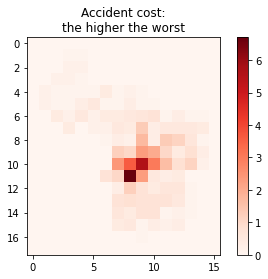

In [98]:
accidentsPenalty_graphGrid = np.zeros((num_1km_northing_boxes, num_1km_easting_boxes))

for node in sorted(bristol_grid_graph.nodes()):
    x = num_1km_northing_boxes - node[1] - 1
    y = node[0]
    accidentsPenalty_graphGrid[x, y] = accidents_penalty_cost(
        bristol_grid_graph.nodes[node]["number_of_accidents"]
    )

fig = plt.imshow(accidentsPenalty_graphGrid, cmap='Reds')
plt.title("Accident cost:\nthe higher the worst")
plt.colorbar(fig, cmap='Reds')
plt.show()

**Criminality Index**

In [99]:
crime_records_2018_box = dict()
for node, data in bristol_grid_graph.nodes(data=True):
    lat, lon = data["latitude_longitude"]
    for _, row in crime_records_gdf_2018.iterrows():
        ward_geometry = row.geometry
        if ward_geometry.contains(Point(lon, lat)):
            crime_records_2018_box[node] = row.all_crimes_rate_per_1000_ward_population
            continue

In [100]:
# Set as node attribute
nx.set_node_attributes(
    bristol_grid_graph,
    crime_records_2018_box,
    name="crime_rate"
)

In [101]:
def criminality_penalty_cost(crime_rate, max_reward=10):
    return min(crime_rate+1, 500) * max_reward/500

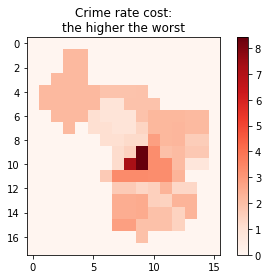

In [102]:
criminalityPenalty_graphGrid = np.zeros((num_1km_northing_boxes, num_1km_easting_boxes))

for node in sorted(bristol_grid_graph.nodes()):
    x = num_1km_northing_boxes - node[1] - 1
    y = node[0]
    criminalityPenalty_graphGrid[x, y] = criminality_penalty_cost(
        bristol_grid_graph.nodes[node]["crime_rate"]
    )

fig = plt.imshow(criminalityPenalty_graphGrid, cmap='Reds')
plt.title("Crime rate cost:\nthe higher the worst")
plt.colorbar(fig, cmap='Reds')
plt.show()

**Total Reward**

In [117]:
# Set as node attribute
nx.set_node_attributes(
    bristol_grid_graph,
    {node: int(
        sum([
            bats_reward(data["number_of_bats"]),
            moths_reward(data["number_of_moths"]),
            lights_reward(data["number_of_street_lights"])
        ])
    ) for node, data in bristol_grid_graph_directed.nodes(data=True)},
    name="reward"
)

#### Corridors Construction based on Least-Cost

Dijkstra’s algorithm has been implemented to determine the Least Cost path between specific centroids, to identify potential dark corridors. The cost function we defined accounts for the number of bats, moths, street lights and penalties for switching lights off

In [ ]:
# From undirected to directed graph
bristol_grid_graph_directed = bristol_grid_graph.to_directed()
nx.is_directed(bristol_grid_graph_directed)

###### Cost Function

In [119]:
# Set as node attribute
nx.set_node_attributes(
    bristol_grid_graph_directed,
    {node: int(
        sum([
            bats_cost(data["number_of_bats"]),
            moths_cost(data["number_of_moths"]),
            lights_cost(data["number_of_street_lights"]),
            0.5*accidents_penalty_cost(data["number_of_accidents"]),
            0.5*criminality_penalty_cost(data["crime_rate"])
        ])
    ) for node, data in bristol_grid_graph_directed.nodes(data=True)},
    name="cost"
)

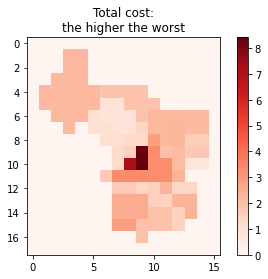

In [120]:
totalCost_graphGrid = np.zeros((num_1km_northing_boxes, num_1km_easting_boxes))

for node in sorted(bristol_grid_graph.nodes()):
    x = num_1km_northing_boxes - node[1] - 1
    y = node[0]
    totalCost_graphGrid[x, y] = bristol_grid_graph_directed.nodes[node]["cost"]

fig = plt.imshow(criminalityPenalty_graphGrid, cmap='Reds')
plt.title("Total cost:\nthe higher the worst")
plt.colorbar(fig, cmap='Reds')
plt.show()

In [121]:
# Weight attribute for Dijkstra algorithm
for node, data in bristol_grid_graph_directed.nodes(data=True):

    for neighbor in bristol_grid_graph_directed.neighbors(node):

        bristol_grid_graph_directed[node][neighbor]['weight'] = int(
           bristol_grid_graph_directed.nodes[neighbor]['cost']
        )

##### Least Cost Path between 2 points

Here is an example of how Dijkstra algorithm can be used with the defined cost matrix to find an optimal dark corridor

In [122]:
from_node, to_node = (9,1), (10,6)
length, path = nx.bidirectional_dijkstra(bristol_grid_graph_directed, from_node, to_node)

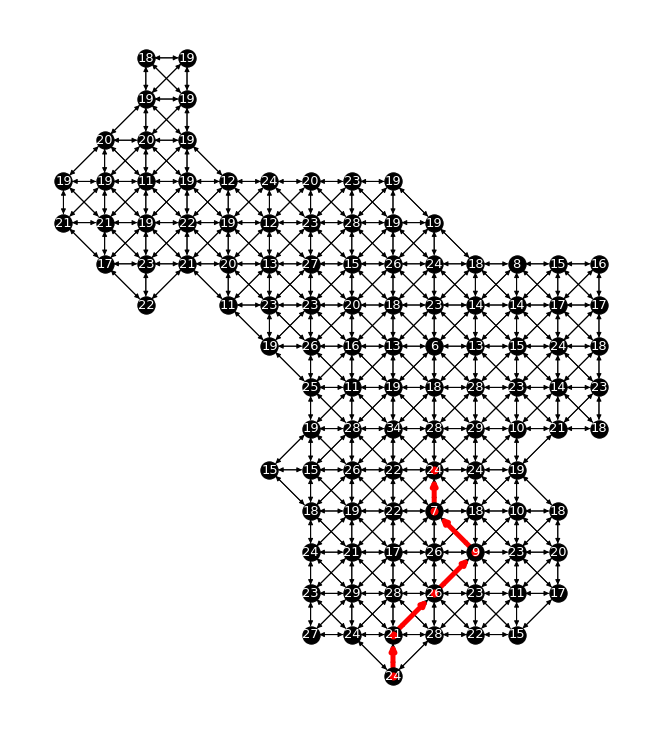

In [123]:
plt.figure(figsize=(9,10))
nx.draw(bristol_grid_graph_directed,pos,node_color='k')
# draw path in red
path_edges = list(zip(path,path[1:]))
nx.draw_networkx_nodes(bristol_grid_graph_directed,pos,nodelist=path,node_color='r',node_size=50)
nx.draw_networkx_edges(bristol_grid_graph_directed,pos,edgelist=path_edges,edge_color='r',width=5)
labels = nx.get_node_attributes(bristol_grid_graph_directed, 'cost') 
nx.draw_networkx_labels(bristol_grid_graph_directed, pos,labels=labels, font_size=13, font_color="white")
plt.axis('equal')
plt.show()

#### Simulating Bat Movements with Stochastic Processes

In [124]:
# list of the starting nodes on which to perform the walks
centers_corresponding_box = [get_approximated_EastNorth_coords(*center) for center in centers]
starting_nodes = [{data['easting_northing']:node for node, data in bristol_grid_graph.nodes(data=True)}[center_corresponding_box] for center_corresponding_box in centers_corresponding_box]

###### Graph random walk

In [126]:
def plot_walk_from_nodes_list(visited_graph_coords):

  # plot a given nodes path on map
  
  ##### Input
  # visited_graph_coords: iterable, visited nodes list
  
  # transform into polar coordinates
  visited_EastNorth = [bristol_grid_graph.nodes[vis]['latitude_longitude'] for vis in visited_graph_coords]
  # separate x and y coordinates
  lat = [vis[0] for vis in visited_EastNorth]
  lon = [vis[1] for vis in visited_EastNorth]

  # Plot scatter map
  fig = (
      px.scatter_mapbox(#line_mapbox(
          lat=lat,
          lon=lon,
          animation_frame=[str(idx) for idx in range(len(lat))]
          )
      .update_traces(
          mode = "markers", marker_sizemin=30, marker_opacity=1)
      .update_layout(
          mapbox={
              "style": 'carto-positron', #'open-street-map'
              "zoom": 9.4,
              "layers": [
                  {
                      "source": json.loads(
                          bristol_geodata.geometry.to_json()
                      ),
                      "below": "traces",
                      "type": "line",
                      "color": "purple",
                      "line": {"width": 1.5},
                  }
              ]
          },
          margin={"l": 0, "r": 0, "t": 0, "b": 0},
      )
  )
  fig.show()
  return


def extract_average_preferred_paths(G, p_T_dict):

  # return the average of the preferred paths densities
  
  ##### Input
  # G: nx.Graph, graph on which the walks were performed
  # p_T_dict: np.array, state vectors dictionary

  ##### Output
  # avg_behavior_matrix: np.array, average of the preferred paths densities

  behavior_matrices_dict = {}
  for node in p_T_dict.keys():
    behavior_matrices_dict[node] = np.zeros((num_1km_northing_boxes, num_1km_easting_boxes))
    for idx in range(len(G.nodes())):
      y, x = list(G.nodes())[idx]
      x = num_1km_northing_boxes - x - 1
      behavior_matrices_dict[node][(x, y)] = p_T_dict[node][idx]
  avg_behavior_matrix = np.sum(list(behavior_matrices_dict.values()), axis=0)
  print(avg_behavior_matrix.shape)

  return avg_behavior_matrix

In [127]:
# https://stackoverflow.com/questions/37311651/get-node-list-from-random-walk-in-networkx
def graph_random_walk(G, starting_nodes, walkLength=20, random_seed=0):

  # implements graph random walk

  ##### Input
  # G: nx.Graph, graph on which to define the random walk
  # starting_nodes: iterable, nodes from where to start the walks
  # walkLength: int, number of steps of the walks
  # random_seed: int, initial random seed for the sampling sessions

  ##### Output
  # visited_graph_coords_dict: dict, simulated paths
  # T: np.array, transiction matrix associated to the random walk
  # p_T_dict: dict, simulated paths

  # extract graph adjacency matrix in array type
  A = nx.adjacency_matrix(G)
  A = A.todense()
  A = np.array(A, dtype = np.float64)

  # extract degree matrix
  D = np.diag(np.sum(A, axis=0))
  # extract transition matrix
  T = np.dot(np.linalg.inv(D), A)

  # define dictionaries to trace walks paths and densities after walkLength steps
  visited_dict = {}
  visited_graph_coords_dict = {}
  p_T_dict = {}
  # iterate over the starting nodes
  for first_node_RW in starting_nodes:
    # keep track of the path inside a dedicated list
    visited_dict[first_node_RW] = [list(G.nodes()).index(first_node_RW)]
    # select correspondent density
    p_t = T[visited_dict[first_node_RW][-1]].reshape(-1,1)
    # initialize state vector
    p_T_dict[first_node_RW] = p_t.copy()
    # set random seed for reproducibility
    np.random.seed(random_seed)
    # iterate to perform walkLength steps
    for k in range(walkLength):
      # evaluate next state vector
      p_T_dict[first_node_RW] = np.dot(T,p_T_dict[first_node_RW])
      # choose the next node sampling from the current probability density
      visited_dict[first_node_RW].append(int(np.random.choice(range(len(G.nodes())), 1, p=p_t.flatten() / p_t.sum())))
      # update node density
      p_t = T[visited_dict[first_node_RW][-1]].reshape(-1,1)
    # translate path sequence into nodes coordinates
    visited_graph_coords_dict[first_node_RW] = [list(G.nodes())[nd] for nd in visited_dict[first_node_RW]]
    print(f'Visited nodes after {first_node_RW}: {visited_graph_coords_dict[first_node_RW][1:]}')
  
  return visited_graph_coords_dict, T, p_T_dict

In [128]:
# define random walk length
walkLength = 15
# random seed for reproducibility
random_seed = 123

visited_graph_coords_dict, T, p_T_dict = graph_random_walk(bristol_grid_graph, starting_nodes, walkLength, random_seed)

Visited nodes after (7, 3): [(7, 4), (8, 5), (7, 5), (7, 4), (8, 3), (9, 4), (9, 5), (10, 5), (10, 4), (10, 3), (11, 4), (12, 3), (11, 4), (11, 5), (12, 4)]
Visited nodes after (12, 3): [(11, 3), (11, 4), (10, 3), (9, 2), (9, 1), (9, 2), (10, 2), (9, 1), (9, 2), (10, 3), (11, 4), (12, 3), (11, 4), (11, 5), (12, 4)]
Visited nodes after (10, 5): [(10, 6), (9, 7), (10, 7), (11, 7), (11, 8), (10, 9), (9, 10), (9, 11), (9, 12), (8, 13), (8, 12), (7, 13), (6, 13), (7, 12), (8, 13)]
Visited nodes after (6, 6): [(7, 7), (7, 8), (8, 9), (7, 10), (8, 10), (9, 11), (9, 10), (9, 11), (9, 12), (8, 13), (8, 12), (7, 13), (6, 13), (7, 12), (8, 13)]
Visited nodes after (8, 7): [(9, 6), (8, 6), (7, 6), (8, 7), (9, 6), (9, 7), (8, 8), (8, 7), (9, 7), (9, 8), (9, 9), (8, 10), (9, 11), (8, 12), (7, 11)]
Visited nodes after (13, 7): [(14, 7), (13, 7), (14, 8), (14, 9), (14, 10), (14, 9), (13, 8), (14, 9), (13, 9), (14, 9), (14, 8), (14, 7), (14, 8), (13, 7), (12, 8)]
Visited nodes after (7, 8): [(7, 9), (7

In [ ]:
plot_walk_from_nodes_list(list(visited_graph_coords_dict.values())[0]) 

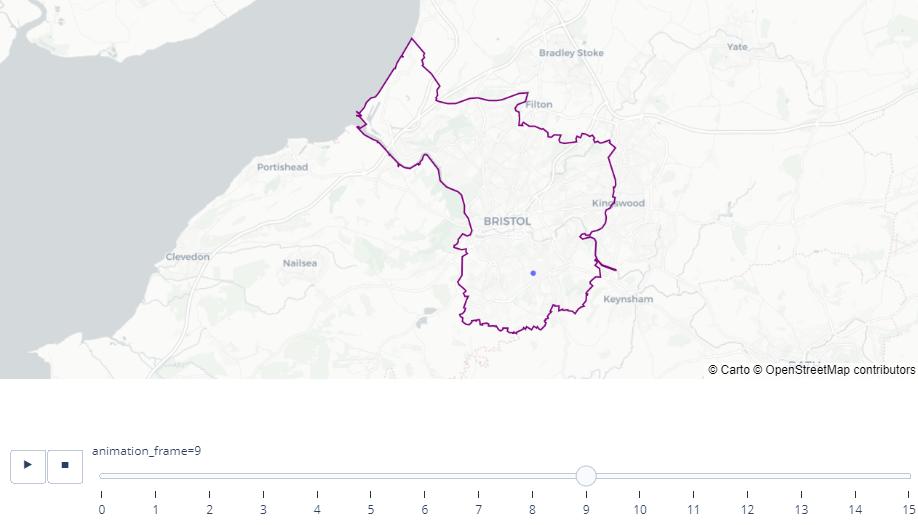

In [ ]:
avg_behavior_matrix = extract_average_preferred_paths(bristol_grid_graph, p_T_dict)
px.imshow(avg_behavior_matrix)

###### Graph reward-based walk

In [131]:
for node in bristol_grid_graph_directed.nodes():
    total_reward = sum([bristol_grid_graph_directed.nodes[neigh]['reward'] for neigh in bristol_grid_graph_directed.neighbors(node)])
    for neigh in bristol_grid_graph_directed.neighbors(node):
        bristol_grid_graph_directed[node][neigh]['weight'] = bristol_grid_graph_directed.nodes[neigh]['reward'] / total_reward

In [ ]:
# define walk length
walkLength = 15
# random seed for reproducibility
random_seed = 123

visited_graph_coords_dict, A, p_T_dict = graph_random_walk(bristol_grid_graph, starting_nodes, walkLength, random_seed)

idx = 0
plot_walk_from_nodes_list(list(visited_graph_coords_dict.values())[idx]) 

avg_behavior_matrix = behavior_matrix = extract_average_preferred_paths(bristol_grid_graph, p_T_dict)

In [133]:
def graph_rewardBased_walk(G_directed, starting_nodes, walkLength=20, random_seed=0):

  # implements reward-based walk on graph

  ##### Input
  # G_directed: nx.Graph, directed graph on which to define the reward-based walk;
  #   its adjacency matrix must already be the transition matrix of the associated Markov chain
  # starting_nodes: iterable, nodes from where to start the walks
  # walkLength: int, number of steps of the walks
  # random_seed: int, initial random seed for the sampling sessions

  ##### Output
  # visited_graph_coords_dict: dict, simulated paths
  # T: np.array, transiction matrix associated to the Markov chain
  # p_T_dict: dict, simulated paths

  # extract graph adjacency matrix in array type
  T = nx.adjacency_matrix(G_directed)
  T = T.todense()
  T = np.array(T, dtype = np.float64)
  
  # define dictionaries to trace walks paths and densities after walkLength steps
  visited_dict = {}
  visited_graph_coords_dict = {}
  p_T_dict = {}
  # iterate over the starting nodes
  for first_node_RW in starting_nodes:
    # keep track of the path inside a dedicated list
    visited_dict[first_node_RW] = [list(G_directed.nodes()).index(first_node_RW)]
    # select correspondent density
    p_t = T[visited_dict[first_node_RW][-1]].reshape(-1,1)
    # initialize state vector
    p_T_dict[first_node_RW] = p_t.copy()
    # set random seed for reproducibility
    np.random.seed(random_seed)
    # iterate to perform walkLength steps
    for k in range(walkLength):
      # evaluate next state vector
      p_T_dict[first_node_RW] = np.dot(T,p_T_dict[first_node_RW])
      # choose the next node sampling from the current probability density
      visited_dict[first_node_RW].append(int(np.random.choice(range(len(G_directed.nodes())), 1, p=p_t.flatten() / p_t.sum())))
      # update node density
      p_t = T[visited_dict[first_node_RW][-1]].reshape(-1,1)
    # translate path sequence into nodes coordinates
    visited_graph_coords_dict[first_node_RW] = [list(G_directed.nodes())[nd] for nd in visited_dict[first_node_RW]]
    print(f'Visited nodes after {first_node_RW}: {visited_graph_coords_dict[first_node_RW][1:]}')
  
  return visited_graph_coords_dict, T, p_T_dict

In [ ]:
# define random walk length
walkLength = 10
# random seed for reproducibility
random_seed = 123

visited_graph_coords_dict, T, p_T_dict = graph_rewardBased_walk(bristol_grid_graph_directed, starting_nodes, walkLength, random_seed)

idx = 0
plot_walk_from_nodes_list(list(visited_graph_coords_dict.values())[idx])

avg_behavior_matrix = behavior_matrix = extract_average_preferred_paths(bristol_grid_graph_directed, p_T_dict)

In [ ]:
px.imshow(avg_behavior_matrix)

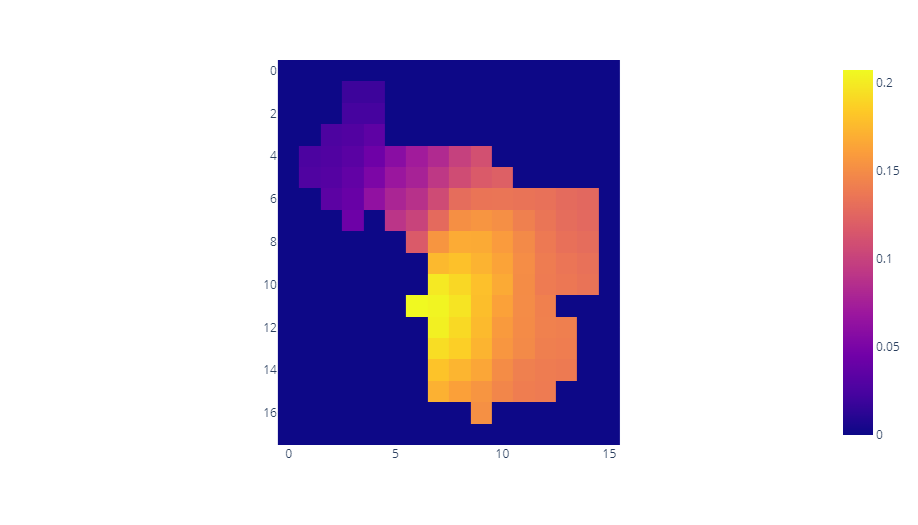

###### Least-Cost Corridors on simulation lattices

In [136]:
# Set as node attribute
nx.set_node_attributes(
    bristol_grid_graph_directed,
    {node: avg_behavior_matrix[num_1km_northing_boxes - node[1] - 1, node[0]] for
     node in bristol_grid_graph.nodes()},
    name="avg_behavior"
)

In [137]:
for node, _ in bristol_grid_graph_directed.nodes(data=True):

    for neighbor in bristol_grid_graph_directed.neighbors(node):

        bristol_grid_graph_directed[node][neighbor]['weight'] = 1 - bristol_grid_graph_directed.nodes[neighbor]['avg_behavior']

In [138]:
from_node, to_node = starting_nodes[6], starting_nodes[9]
length, path = nx.bidirectional_dijkstra(bristol_grid_graph_directed, from_node, to_node)

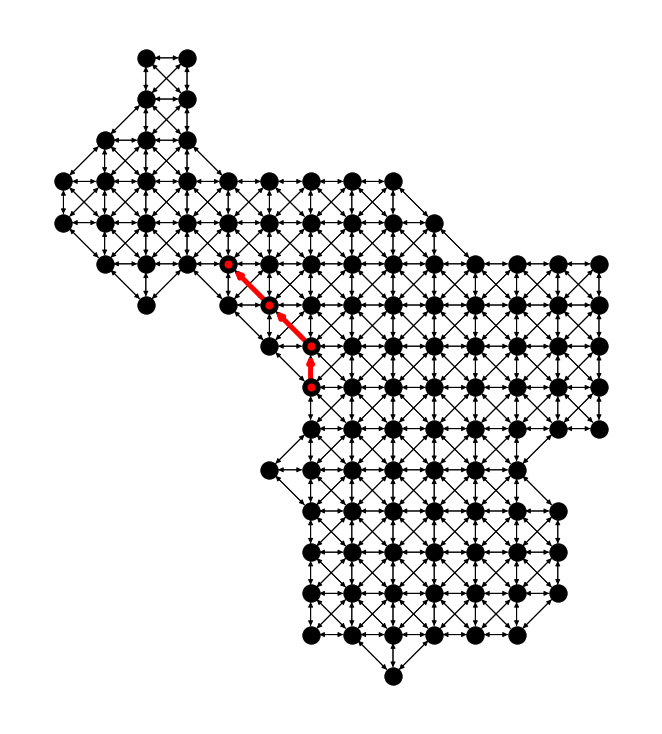

In [139]:
plt.figure(figsize=(9,10))
nx.draw(bristol_grid_graph_directed,pos,node_color='k')
# draw path in red
path_edges = list(zip(path,path[1:]))
nx.draw_networkx_nodes(bristol_grid_graph_directed,pos,nodelist=path,node_color='r',node_size=50)
nx.draw_networkx_edges(bristol_grid_graph_directed,pos,edgelist=path_edges,edge_color='r',width=5)
labels = nx.get_node_attributes(bristol_grid_graph_directed, 'weight') 
nx.draw_networkx_labels(bristol_grid_graph_directed, pos,labels=labels, font_size=13, font_color="white")
plt.axis('equal')
plt.show()

#### Agent Based Model

Agent-based modelling (ABM) simulates Social-Ecological-Systems (SESs) based on the decision-making and actions of individual actors or actor groups, their interactions with each other, and with ecosystems.

ABMs have been widely used to study animal movement for a variety of species, including birds and fish, as well as to simulate ecological dynamics in natural systems with interacting and competing entities.

Therefore, an ABM seemed to us a viable alternative approach to solving this challange.



In [ ]:
!pip install mesa

In [141]:
from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector

from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.modules import CanvasGrid, ChartModule, TextElement
from mesa.visualization.UserParam import UserSettableParameter 

##### Prepare data

In this subsection, available data are further preprocessed to meet ABM input requirements.

In [142]:
# Number of bats per 1km box in selected years (2019-20)
bats_per_grid_box_year = bat_records_df[['year_date', 'easting', 'northing', 'numeric_abundance']].copy()

bats_per_grid_box_year['eastNorth_grid_box'] = bats_per_grid_box_year[['easting','northing']].apply(
    lambda x: get_approximated_EastNorth_coords(*x), axis=1)

bats_per_grid_box_year['year'] = [str(date)[0:4] for date in bats_per_grid_box_year['year_date'].values]
bats_per_grid_box_year = bats_per_grid_box_year.loc[bats_per_grid_box_year.year.isin(['2019', '2020'])] #.isin(['2018'])

bats_per_grid_box_year = bats_per_grid_box_year.groupby('eastNorth_grid_box').numeric_abundance.sum().to_dict()

graphCoords_to_batsNumber_dict_sub = {node: bats_per_grid_box_year.get(data['easting_northing'], 0) for
     node, data in bristol_grid_graph.nodes(data=True)}

In [143]:
# Number of moth per 1km box in selected years (2019-20)
moth_per_grid_box_year = moth_records_df[['year_date', 'easting', 'northing', 'numeric_abundance']].copy()

moth_per_grid_box_year['eastNorth_grid_box'] = moth_per_grid_box_year[['easting','northing']].apply(
    lambda x: get_approximated_EastNorth_coords(*x), axis=1)

moth_per_grid_box_year['year'] = [str(date)[0:4] for date in moth_per_grid_box_year['year_date'].values]
moth_per_grid_box_year = moth_per_grid_box_year.loc[moth_per_grid_box_year.year.isin(['2019', '2020'])] #.isin(['2018'])

moth_per_grid_box_year = moth_per_grid_box_year.groupby('eastNorth_grid_box').numeric_abundance.sum().to_dict()

graphCoords_to_mothsNumber_dict_sub = {node: moth_per_grid_box_year.get(data['easting_northing'], 0) for
     node, data in bristol_grid_graph.nodes(data=True)}

In [144]:
# Number of plants per 1km box 
green_alley_species_df['eastNorth_grid_box'] = green_alley_species_df[['easting','northing']].apply(lambda x: get_approximated_EastNorth_coords(*x), axis=1)

green_alley_species_count_dict = green_alley_species_df.groupby('eastNorth_grid_box').size().to_dict()

graphCoords_to_green_alley_species = {node: green_alley_species_count_dict.get(data['easting_northing'], 0) for
     node, data in bristol_grid_graph.nodes(data=True)}

In [145]:
# Number of osm urban nodes per 1km box
OSM_nodes_df["in_Bristol"] = OSM_nodes_df.apply(lambda x: 
                                                point_in_bristol(x.latitude, x.longitude), axis = 1)

OSM_nodes_df_in_Bristol = OSM_nodes_df.loc[OSM_nodes_df["in_Bristol"]]

OSM_nodes_df_in_Bristol['eastNorth_grid_box'] = OSM_nodes_df_in_Bristol[['easting','northing']].apply(lambda x: get_approximated_EastNorth_coords(*x), axis=1)

OSM_nodes_count_dict = OSM_nodes_df_in_Bristol.groupby('eastNorth_grid_box').size().to_dict()

graphCoords_to_OSM_nodes = {node: OSM_nodes_count_dict.get(data['easting_northing'], 0) for
     node, data in bristol_grid_graph.nodes(data=True)}

In [146]:
# Number of street lamps per 1km box

street_light_df['eastNorth_grid_box'] = street_light_df[['easting','northing']].apply(lambda x: get_approximated_EastNorth_coords(*x), axis=1)

street_light_count_dict = street_light_df.groupby('eastNorth_grid_box').size().to_dict()

graphCoords_to_lampsNumber_dict = {node: street_light_count_dict.get(data['easting_northing'], 0) for
     node, data in bristol_grid_graph.nodes(data=True)}



In [147]:
external_nodes = [node for node, data in grid_graph.nodes(data=True) 
                  if not point_in_bristol(*data['latitude_longitude'])]

##### Define Agent class

The Bristol ABM includes different type of agents:

* bat
* moth
* lamp
* urban area
* green area
* area out of Bristol City.

Only bat and lamp are supposed to be alive agent, moving and7or updating their status as response of surrounding environment and other agents bahaviour.

Lamp agents could be set to three different lighting status: totally on, half on, off. By default lamps are on.

At each time step, bats moves to one of the cells neighboring its current location to improve their happiness (in similar fashion of Schelling's segregation model) until threshold value is reached. Happiness score is defined as a weighted combination of resources (moth), favorable conditions (presence of other bats and/or plants) and unfavorable conditions (urban areas and/or lamps on). When a bat moves, immediately in the new visited cell the public lights are lowered by half the value.

Moth and areas act instead as placeholders, indicating available resources and/or characteristic of a certain location.





In [148]:
# define agent class

class BristolAgent(Agent):
    # 1 Initialization
    def __init__(self, model, ids, agent_type, agent_perc=1):
        '''
        unique_id: Unique identifier for the agent.
        x, y: Agent initial location.
        agent_type: Indicator for the agent's type (bat, moth, lamp)
        #agent_num: Indicator for the agent's abundance/density 
        '''

        #super().__init__(pos, model) #inherit
        self.unique_id = ids
        self.model = model
        self.type = agent_type
        self.perc = agent_perc

    # 2 Step function
    def step(self):
        
        if self.type == 'bat': 
            
            # check if happy in actual position
            
            # compute happy score
            actual_pos = self.pos
            dark = 0
            moth = False
            green = False
            bats = 0
            urban = False
            for local_agent in self.model.grid[actual_pos[0]][actual_pos[1]]:
                if local_agent.type == 'moth': moth=True
                elif local_agent.type == 'building': urban=True
                elif local_agent.type == 'green': green=True
                elif local_agent.type == 'bat': bats+=1
                elif local_agent.type == 'lamp': dark = 1 - local_agent.perc

            actual_score = 2*moth + 0.1*(bats-1) + green + dark - 0.5*urban #- (not dark) + (not urban) 
            
            if actual_score>= self.model.happy_threshold:
                self.model.num_happy_bats+=1
                
            # if unhappy
            else: 
                #look in neighborhood and compute happy score:
                score = []
                neighbor_positions = self.model.grid.get_neighborhood(self.pos, moore = True) #, include_center = True)  #moore = True to add diagonal neighbors
                neighbor_positions_in_city = list(set(neighbor_positions) - set(external_nodes))
                for n_pos in neighbor_positions:
                    dark = False
                    moth = False
                    green = False
                    bats = 0
                    urban = False

                    for neighbor_agent in self.model.grid[n_pos[0]][n_pos[1]]:
                        if neighbor_agent.type == 'moth': moth=True
                        elif neighbor_agent.type == 'building': urban=True
                        elif neighbor_agent.type == 'green': green=True
                        elif neighbor_agent.type == 'bat': bats+=1
                        elif neighbor_agent.type == 'lamp': dark = 1 - neighbor_agent.perc

                    n_score = 2*moth + 0.1*(bats-1) + green + dark - 0.5*urban #- (not dark) + (not urban) 

                    score.append(n_score)

                # pick the best position according to score (if tie, pick at random)
                score = np.array(score)
                best_score_index = np.random.choice(np.argwhere(score == np.max(score)).reshape(-1))
                best_score = score[best_score_index]
                best_pos = neighbor_positions[best_score_index]

                # move to that position
                self.model.grid.move_agent(self, best_pos)

                # if not urban, and on, switch light off
                best_pos_agents = self.model.grid[best_pos[0]][best_pos[1]]
                best_pos_agent_types = [a.type for a in best_pos_agents]
                if not 'building' in best_pos_agent_types:
                    lamp_agent_in_best_pos = best_pos_agents[best_pos_agent_types.index('lamp')]
                    if lamp_agent_in_best_pos.perc > 0.5: # if on
                        lamp_agent_in_best_pos.perc = 0.5
                    elif lamp_agent_in_best_pos.perc > 0: # if half on
                        lamp_agent_in_best_pos.perc = 0
                        self.model.num_on_lamps -= 1
                
            
    

      

##### Define Model class

Bristol ABM is defined as a 2D grid, each cell can contain 0, 1 or more agents. As in the previous model, each cell is 1 Km $\times$ 1 Km square.

The grid is initialized placing bat, moth, lamp, green and urban area agents according to real observed data. In this case, only 2019 and 2020 moth and bat records were considered.

At each simulation step, agents are activated in random order. The simulation terminates when all present bat agents are happy.


In [149]:
# define model class

class BristolModel(Model):

    # constructor method
    def __init__(self, height, width, bats, moths, lamps, greens, buildings, outs, lamp_density, green_density, building_density, happy_threshold):

      self.height = height
      self.width = width
      self.bats = bats
      self.moths = moths
      self.lamps = lamps
      self.greens = greens
      self.buildings = buildings
      self.outs = outs
      self.lamp_density = lamp_density
      self.green_density = green_density
      self.building_density = building_density
      self.happy_threshold = happy_threshold


      
      self.grid = MultiGrid(width,height,torus=False)
      self.schedule = RandomActivation(self) # at each simulation step activate agents in random order

      self.num_happy_bats = 0 # happy bat agents counter
      self.num_bats = 0 # bat agents counter
      self.num_on_lamps = 0 # lamp (switched on) agents counter
      self.datacollector = DataCollector(
          {"num_happy_bats": "num_happy_bats", "num_on_lamps": "num_on_lamps"},    # Model-level count of happy agents and lamp (switched on) agents
          {"x": lambda a: a.pos[0], "y": lambda a: a.pos[1]}  # For testing purposes, agent's individual x and y
          )
      
      # agents set up
      for cell in self.grid.coord_iter():
        x = cell[1]
        y = cell[2]
        bat_in_cell = False 
        if not (x,y) in self.outs: # fill only cell in city

          # add moth if present
          if self.moths[(x,y)] > 0:
            agent = BristolAgent(self, 'moth'+str((x,y)),'moth')
            self.grid.place_agent(agent, (x, y))
            self.schedule.add(agent)

          # add bat if present
          if self.bats[(x,y)] > 0:
            agent = BristolAgent(self, 'bat'+str((x,y)), 'bat')
            self.grid.place_agent(agent, (x, y))
            self.schedule.add(agent)
            self.num_bats += 1
            #bat_in_cell = True
            
          # add green area if present/greater than density threshold
          if self.greens[(x,y)] > self.green_density:
            agent = BristolAgent(self, 'green'+str((x,y)), 'green')
            self.grid.place_agent(agent, (x, y))
            self.schedule.add(agent)
            
          # add urban area if present/greater than density threshold
          if self.buildings[(x,y)] > self.building_density:
            agent = BristolAgent(self, 'building'+str((x,y)), 'building')
            self.grid.place_agent(agent, (x, y))
            self.schedule.add(agent)

          # add lamp 
          light_on = self.lamps[(x,y)] > self.lamp_density
          agent = BristolAgent(self, 'lamp'+str((x,y)), 'lamp', float(light_on)) #(not bat_in_cell)*1
          self.grid.place_agent(agent, (x, y))
          self.schedule.add(agent)
          self.num_on_lamps+= 1 # update counter
        
        else:
            agent = BristolAgent(self, 'out'+str((x,y)), 'out') # agent placeholder for cells out of city boundaries
            self.grid.place_agent(agent, (x, y))
            self.schedule.add(agent)
          

      self.running = True   # enables conditional shut off of the model once a condition is met (false once all the agent are happy)                            
      self.datacollector.collect(self)

      
    def step(self):
      self.num_happy_bats = 0  # 1 Reset counter of happy bats
      self.schedule.step() # perform step

      # 2 collect data
      self.datacollector.collect(self)

      # 3 Stop the model if all agents are happy
      if self.num_happy_bats == self.num_bats: #schedule.get_agent_count():
        self.running = False





##### Define visualization

Finally, the following lines of codes generate a graphical and interactive tool to initialize and run the ABM model.

In [150]:
class HappyBat(TextElement): # Display a text count of how many happy bat agents there are.
  def __init__(self):
    pass

  def render(self, model):
    return "Happy bats: " + str(model.num_happy_bats)

In [151]:
imgPath = os.path.join(dataPath, 'img')

def Bristol_draw(agent):
    # 1
    if agent is None:
        return
    
    # 2
    if agent.type == 'bat': # draw bat
        portrayal = {"Shape": os.path.join(imgPath,'bat_pos.png'), 'scale': 1.,
                     "Layer": 3}
        
    elif agent.type == 'moth': # draw moth
        portrayal = {"Shape": os.path.join(imgPath,'moth_pos.png'), 'scale': 1., 
                     "Layer": 2}
        
    elif agent.type == 'green': # draw green areas
        portrayal = {"Shape": os.path.join(imgPath,'tree_pos.png'), 'scale': 1., 
                     "Layer": 1}
        
    elif agent.type == 'building': # draw green areas
        portrayal = {"Shape": os.path.join(imgPath,'city_pos.png'), 'scale': 1., 
                     "Layer": 1}
        
    elif agent.type == 'out': # gray area out of city boundaries
        portrayal = {"Shape": 'rect', 'w':0.98, 'h':0.98, "Filled": "true", "Color": '#dbdbd9', 
                     "Layer": 0}

    else: # draw lamp
        if agent.perc > 0.5: # light on
            portrayal = {"Shape": 'rect', 'w':0.98, 'h':0.98, "Filled": "true", "Color": '#fcfbc5', 
                         "Layer": 0}
            
        elif agent.perc > 0: # light half on
            portrayal = {"Shape": 'rect', 'w':0.98, 'h':0.98, "Filled": "true", "Color": '#d5d4fc', 
                         "Layer": 0}
        else: # light off
            portrayal = {"Shape": 'rect', 'w':0.98, 'h':0.98, "Filled": "true", "Color": "#b9b8f4",
                         "Layer": 0}
        
        

    return portrayal


In [152]:
height = 18
width = 16
pixel_multiple = 35

# 3
happy_element = HappyBat()
canvas_element = CanvasGrid(Bristol_draw, width, height, width*pixel_multiple, height*pixel_multiple)
happy_chart = ChartModule([{"Label": "num_happy_bats", "Color": "Purple"}])
lamp_chart = ChartModule([{"Label": "num_on_lamps", "Color": "Orange"}])

# 4
model_params = {
    "height": height,
    "width": width,
    "bats" : graphCoords_to_batsNumber_dict_sub, 
    "moths": graphCoords_to_mothsNumber_dict_sub, 
    "lamps": graphCoords_to_lampsNumber_dict, 
    "greens": graphCoords_to_green_alley_species,
    "buildings": graphCoords_to_OSM_nodes,
    "outs": external_nodes,
    "lamp_density": UserSettableParameter("slider", "min lamp per sq. Km", 50, 0, 250, 10),
    "green_density": UserSettableParameter("slider", "min plants per sq. Km", 100, 0, 500, 50),
    "building_density": UserSettableParameter("slider", "min urban OSM nodes per sq. Km", 150, 0, 700, 50),
    "happy_threshold": UserSettableParameter("slider", "min bat happy score", 3, 0, 5, 0.5)
}

# 5
server = ModularServer(BristolModel,
                       [canvas_element, happy_element, happy_chart, lamp_chart],
                       "Bristol Dark corridors", model_params)

##### Run model

In [153]:
# from server import server
#server.port = 8688 # The default 8521
#server.launch()

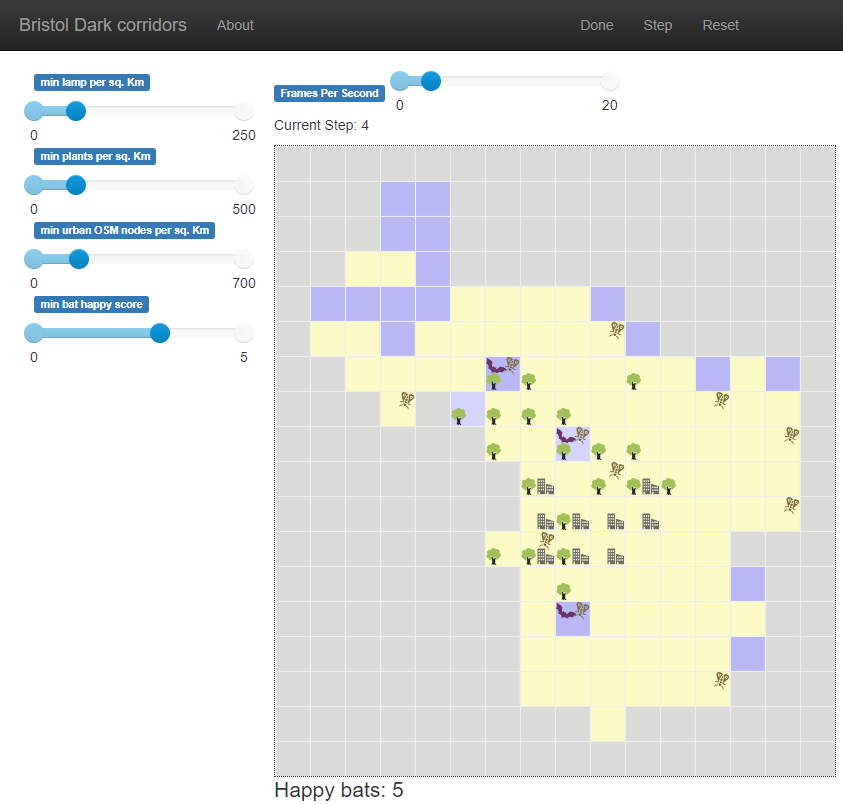

### Conclusions

The developed product can help in predicting the locations most likely to be visited by bats and in the definition of optimal areas in which to reduce public lighting without putting public safety at risk. Moreover, our solutions could be easily generalized and further improved by either correlating data from other sources or by integrating deeper domain knowledge to fine tune models’ hyperparameters.
We believe that the tackled problem is an excellent example of how, even in 2022, deep learning is not always the best approach. The sparsity of data, both from time and spatial perspectives, ruled out all the models with demanding training phases, in favor of more structured simulations.


## 🖼️ Visualisations

## 👓 References

### Bristol Datasets

[data source](https://wdl-data.fra1.digitaloceanspaces.com/bristol/2022_05_30_bristol_datasets.zip)

### External Data
* Bristol's amenities, public, and transport services from Open Street Map

[https://download.geofabrik.de/europe/great-britain/england/bristol-latest.osm.pbf](https://download.geofabrik.de/europe/great-britain/england/bristol-latest.osm.pbf)
* Traffic accidents from Open Data Bristol
[https://opendata.bristol.gov.uk/](https://opendata.bristol.gov.uk/)
* Criminality rate at ward level from Open Data Bristol
[https://opendata.bristol.gov.uk/](https://opendata.bristol.gov.uk/)


### Literature

* Challéat, S., et al., 2021. Grasping darkness: the dark ecological network as a
social-ecological framework to limit the impacts of light pollution on biodiversity.
Ecology and Society 26(1):15. -
https://www.ecologyandsociety.org/vol26/iss1/art15/ES-2020-12156.pdf

* Schirmer, A.E., et al., 2019. Mapping behaviourally relevant light pollution levels to
improve urban habitat planning. Scientific Reports 9, 11925 -
https://rdcu.be/cDGyW

* Hiding from the light - https://www.batcon.org/article/hiding-from-the-lights/

* Artificial light reduces foraging opportunities in wild least horseshoe bats -
https://pubmed.ncbi.nlm.nih.gov/34265558/

* Protecting bats in waterside development June 2018
ba306_bath_bats_and_lighting_guide_10_june_2018.pdf (bathnes.gov.uk)

## ⏭️ Appendix


### Data Distributions per km^2 

#### Number of bats

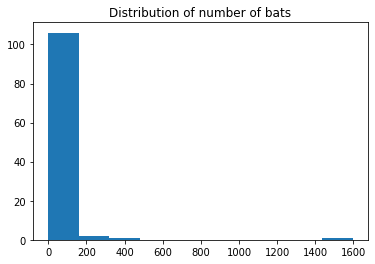

In [154]:
fig = plt.hist(
    [data["number_of_bats"] for node, data in
     bristol_grid_graph.nodes(data=True)]
)
plt.title("Distribution of number of bats")
plt.show()

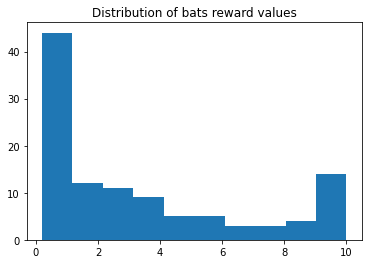

In [155]:
fig = plt.hist(
    [bats_reward(data["number_of_bats"]) for node, data in
    bristol_grid_graph.nodes(data=True)]
)
plt.title("Distribution of bats reward values")
plt.show()

#### Number of Moths

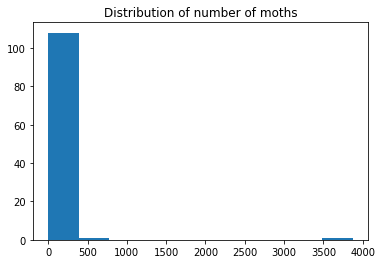

In [156]:
fig = plt.hist(
    [data["number_of_moths"] for node, data in
     bristol_grid_graph.nodes(data=True)]
)
plt.title("Distribution of number of moths")
plt.show()

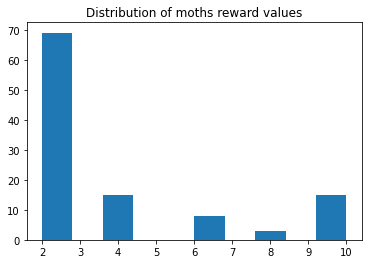

In [157]:
fig = plt.hist(
    [moths_reward(data["number_of_moths"]) for node, data in
    bristol_grid_graph.nodes(data=True)]
)
plt.title("Distribution of moths reward values")
plt.show()

#### Street Lights

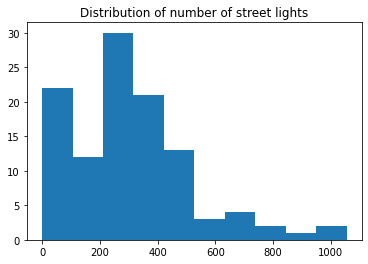

In [158]:
fig = plt.hist(
    [data["number_of_street_lights"] for node, data in
     bristol_grid_graph.nodes(data=True)]
)
plt.title("Distribution of number of street lights")
plt.show()

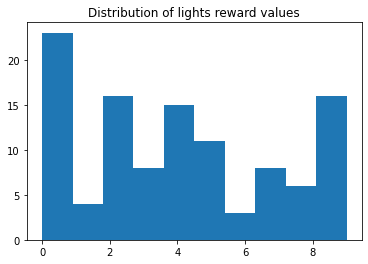

In [159]:
fig = plt.hist(
    [lights_reward(data["number_of_street_lights"]) for node, data in
    bristol_grid_graph.nodes(data=True)]
)
plt.title("Distribution of lights reward values")
plt.show()

#### Accidents

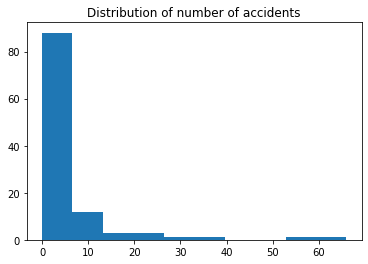

In [160]:
fig = plt.hist(
    [data["number_of_accidents"] for node, data in
     bristol_grid_graph.nodes(data=True)]
)
plt.title("Distribution of number of accidents")
plt.show()

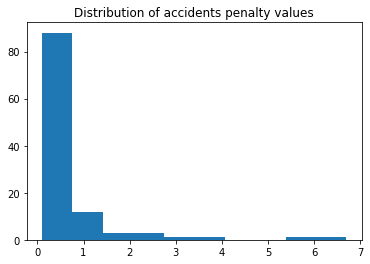

In [161]:
fig = plt.hist(
    [accidents_penalty_cost(data["number_of_accidents"]) for node, data in
    bristol_grid_graph.nodes(data=True)]
)
plt.title("Distribution of accidents penalty values")
plt.show()

#### Criminality

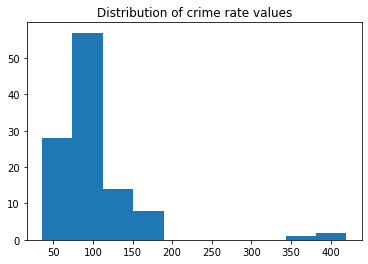

In [162]:
fig = plt.hist(
    [data["crime_rate"] for node, data in
     bristol_grid_graph.nodes(data=True)]
)
plt.title("Distribution of crime rate values")
plt.show()

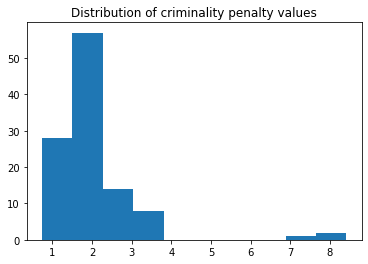

In [163]:
fig = plt.hist(
    [criminality_penalty_cost(data["crime_rate"]) for node, data in
    bristol_grid_graph.nodes(data=True)]
)
plt.title("Distribution of criminality penalty values")
plt.show()